### Settings

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cuda


In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64

imageType = "shapes_3_dims_10_3" #10x10 triangle in 16x16 matrix shapes_3_dims_10_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7

model_directory = "model"

testSample = np.load('/home/jovyan/VecRepV3/data/test_images_16x16.npy')
print(testSample.shape)

(500, 16, 16)


# Visualiation and Calculation using 2 random inputs

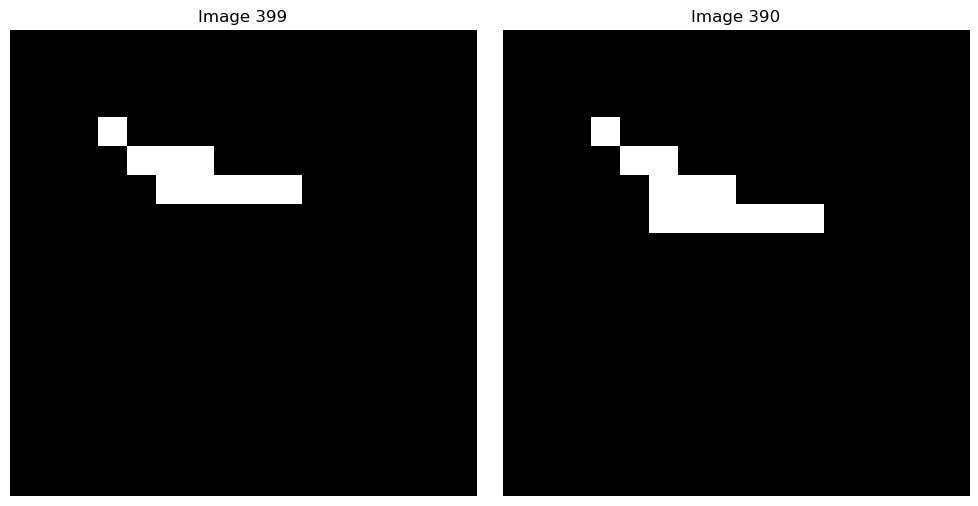

In [4]:
index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
index1 = 399
index2 = 390
input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)

In [5]:
model = models.SimpleCNN2(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                                              f'best_model_{imageType}_{dimensions}d_convlayer1.pt')))
model.eval()

/tmp/ipykernel_33503/1486726852.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_di

SimpleCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=64, bias=True)
)

### Visualisation of Loss score calculation -- Metric 1

In [7]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

print("\nDot product value of model embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_value = imgcalc.get_dp_score(model_transformed[index1], model_transformed[index2])

print("\nDot product value of model transformed embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

input1_transformed_normalised =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
dot_product_value = imgcalc.get_dp_score(input1_transformed_normalised, input2_transformed_normalised)

print("\nDot product value of model transformed normalised embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("\nDifference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.732050895690918

Dot product value of model embeddings:  0.4871748089790344
Loss:  0.24487608671188354

Dot product value of model transformed embeddings:  0.4169406294822693
Loss:  0.3151102662086487

Dot product value of model transformed normalised embeddings:  0.608291745185852
Loss:  0.12375915050506592

Dot product value of BF Method embeddings:  0.7388004533364935
Loss:  0.006749570369720459

Difference in values of BF Method and Model Method:  0.13050872087478638


### Visualisation of KNN-IoU K score calculation -- Metric 2

----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 399: K-Score = 0.6
Intersection sets : [ 23 212 390 399 456 480]
Union sets: [ 23  42 113 212 214 277 390 399 456 480]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   399                    1.000000                            1.000000
    23                    0.649916                            0.685312
    42                    0.555556                            0.670632
   113                    0.539601                            0.671470
   212                    0.608060                            0.745715
   214                    0.632993                            0.596870
   277                    0.603567                            0.586367
   390                    0.732051                            0.738800
   456                    0.632993                            0.688062
   480                    0.60

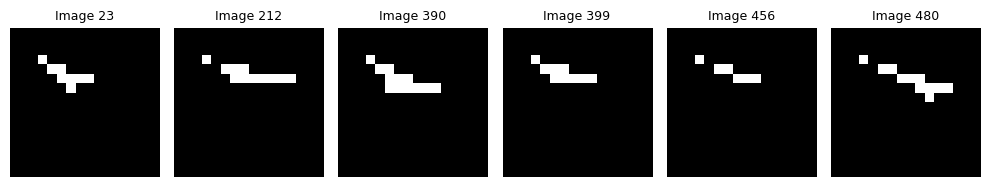


Plotting images in the union set:


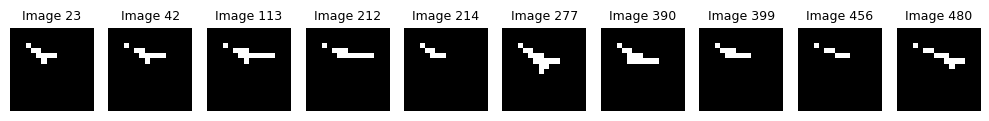


For translationally unique plots: 
Image 23 has no translationally similar images.
Image 42 has no translationally similar images.
Image 113 has no translationally similar images.
Image 212 has no translationally similar images.
Image 214 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 456 has no translationally similar images.
Image 480 has no translationally similar images.

Plotting images in the intersection set:


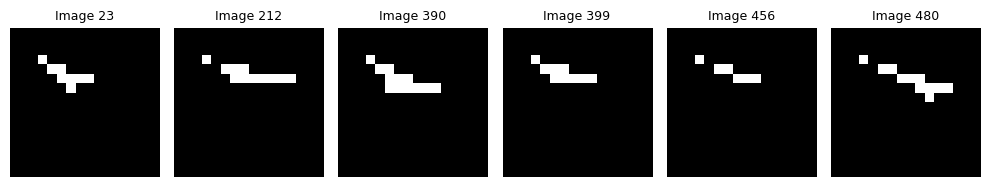


Plotting images in the union set:


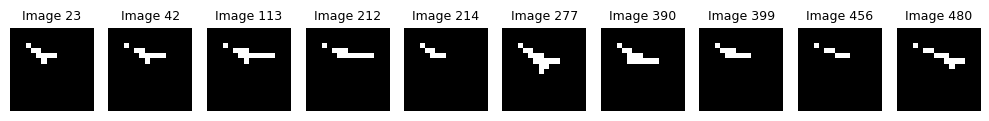


Top 20 values of Vector b
Rank 1: Value = 1.0, Index = 399
Rank 2: Value = 0.732050895690918, Index = 390
Rank 3: Value = 0.6499156951904297, Index = 23
Rank 4: Value = 0.6329931020736694, Index = 214
Rank 5: Value = 0.6329931020736694, Index = 456
Rank 6: Value = 0.6080604791641235, Index = 212
Rank 7: Value = 0.6080602407455444, Index = 480
Rank 8: Value = 0.6035674810409546, Index = 277
Rank 9: Value = 0.5555555820465088, Index = 42
Rank 10: Value = 0.5555555820465088, Index = 62
Rank 11: Value = 0.5396007299423218, Index = 113
Rank 12: Value = 0.5396007299423218, Index = 462
Rank 13: Value = 0.5118578672409058, Index = 27
Rank 14: Value = 0.5118578672409058, Index = 223
Rank 15: Value = 0.5, Index = 493
Rank 16: Value = 0.47920048236846924, Index = 84
Rank 17: Value = 0.4142136573791504, Index = 2
Rank 18: Value = 0.4142136573791504, Index = 17
Rank 19: Value = 0.4142136573791504, Index = 53
Rank 20: Value = 0.4142136573791504, Index = 292

Top 20 values of Vector c
Rank 1: Value 

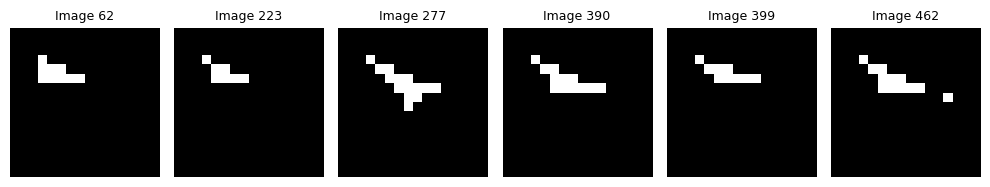


Plotting images in the union set:


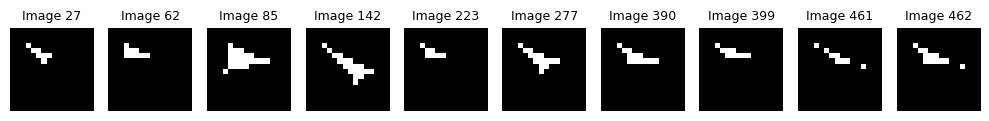


For translationally unique plots: 
Image 27 has no translationally similar images.
Image 62 has no translationally similar images.
Image 85 has no translationally similar images.
Image 142 has no translationally similar images.
Image 223 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 461 has no translationally similar images.
Image 462 has no translationally similar images.

Plotting images in the intersection set:


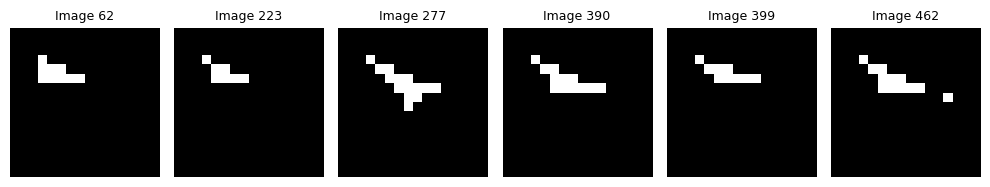


Plotting images in the union set:


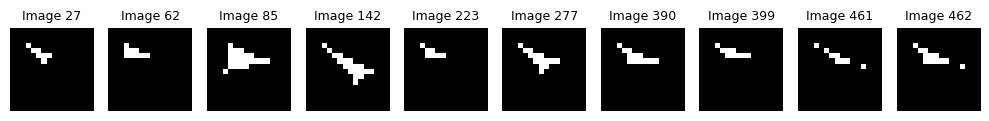


Top 20 values of Vector b
Rank 1: Value = 1.0, Index = 390
Rank 2: Value = 0.8333333730697632, Index = 462
Rank 3: Value = 0.732050895690918, Index = 399
Rank 4: Value = 0.7320506572723389, Index = 62
Rank 5: Value = 0.6973369121551514, Index = 277
Rank 6: Value = 0.5275253057479858, Index = 27
Rank 7: Value = 0.5275253057479858, Index = 223
Rank 8: Value = 0.47709786891937256, Index = 85
Rank 9: Value = 0.4605933427810669, Index = 449
Rank 10: Value = 0.4569857120513916, Index = 142
Rank 11: Value = 0.44337570667266846, Index = 490
Rank 12: Value = 0.4411534070968628, Index = 84
Rank 13: Value = 0.4411534070968628, Index = 329
Rank 14: Value = 0.44115328788757324, Index = 312
Rank 15: Value = 0.4288691282272339, Index = 17
Rank 16: Value = 0.4288691282272339, Index = 23
Rank 17: Value = 0.4288691282272339, Index = 292
Rank 18: Value = 0.4288691282272339, Index = 461
Rank 19: Value = 0.42886900901794434, Index = 53
Rank 20: Value = 0.4288688898086548, Index = 389

Top 20 values of Vec

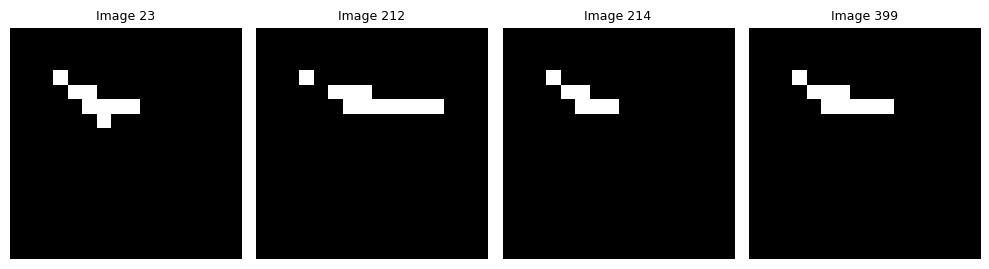


Plotting images in the union set:


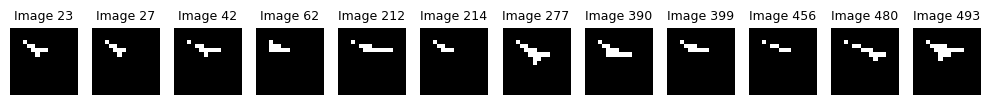


For translationally unique plots: 
Image 23 has no translationally similar images.
Image 27 has no translationally similar images.
Image 42 has no translationally similar images.
Image 62 has no translationally similar images.
Image 212 has no translationally similar images.
Image 214 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 456 has no translationally similar images.
Image 480 has no translationally similar images.
Image 493 has no translationally similar images.

Plotting images in the intersection set:


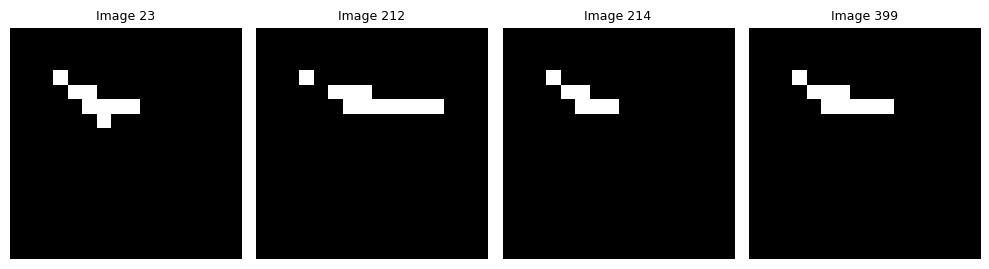


Plotting images in the union set:


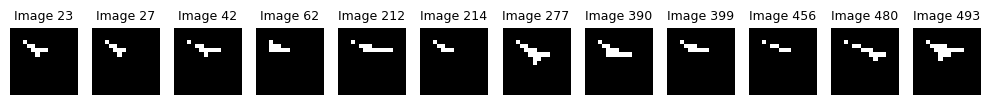

Estimating K-Score for Image 390: K-Score = 0.3333333333333333
Intersection sets : [ 85 277 390 462]
Union sets: [ 27  62  85 152 223 277 390 399 450 462 478 481]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   390                    1.000000                            1.000000
    27                    0.527525                            0.276393
    62                    0.732051                            0.499655
    85                    0.477098                            0.653425
   152                    0.095445                            0.732500
   223                    0.527525                            0.444016
   277                    0.697337                            0.703052
   399                    0.732051                            0.487175
   450                    0.091089                            0.634339
   462                    0.833333                            0.765617
   478        

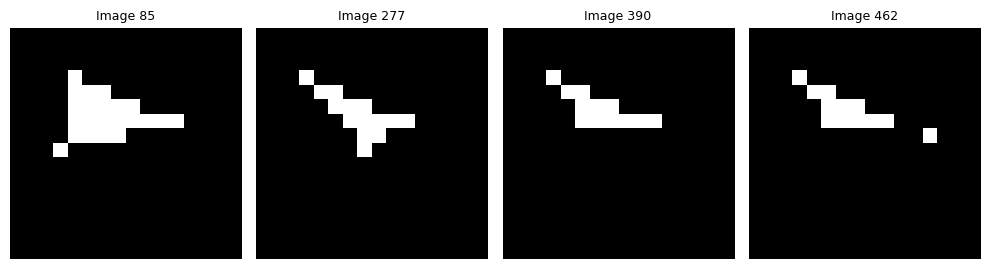


Plotting images in the union set:


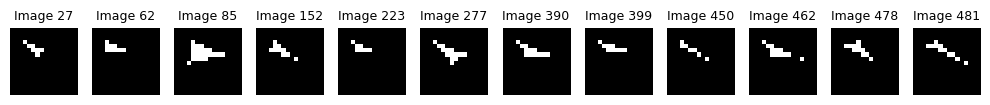


For translationally unique plots: 
Image 27 has no translationally similar images.
Image 62 has no translationally similar images.
Image 85 has no translationally similar images.
Image 152 has no translationally similar images.
Image 223 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 450 has no translationally similar images.
Image 462 has no translationally similar images.
Image 478 has no translationally similar images.
Image 481 has no translationally similar images.

Plotting images in the intersection set:


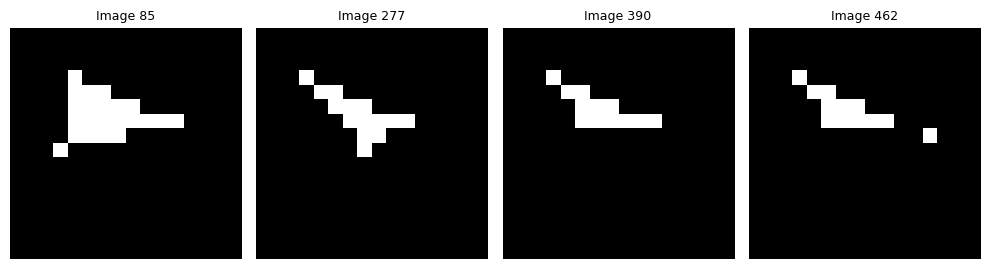


Plotting images in the union set:


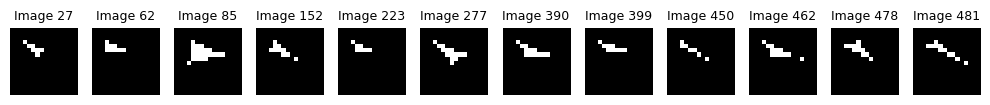

----------------
Transformed Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 399: K-Score = 0.6
Intersection sets : [ 23 212 277 399 456 480]
Union sets: [ 23 165 212 214 277 377 390 399 456 480]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   399                    1.000000                            0.653588
    23                    0.649916                            0.573479
   165                   -0.292893                            0.585319
   212                    0.608060                            0.557880
   214                    0.632993                            0.371409
   277                    0.603567                            0.496784
   377                   -0.105573                            0.506785
   390                    0.732051                            0.416941
   456                    0.632993                            0.842421
   480                  

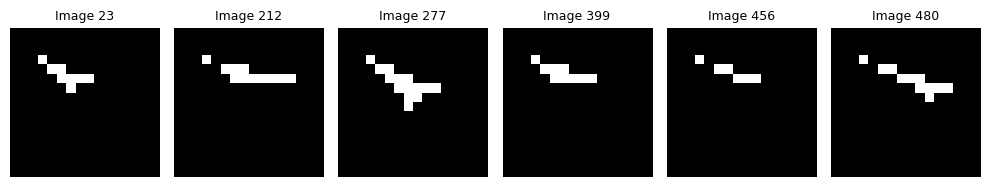


Plotting images in the union set:


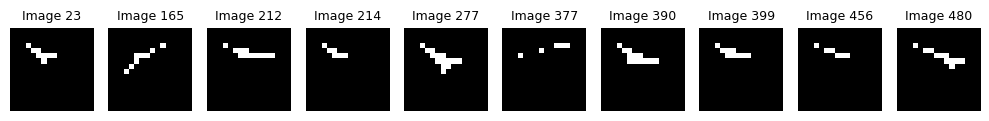


For translationally unique plots: 
Image 23 has no translationally similar images.
Image 165 has no translationally similar images.
Image 212 has no translationally similar images.
Image 214 has no translationally similar images.
Image 277 has no translationally similar images.
Image 377 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 456 has no translationally similar images.
Image 480 has no translationally similar images.

Plotting images in the intersection set:


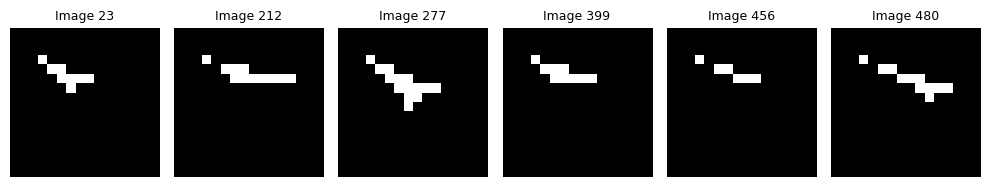


Plotting images in the union set:


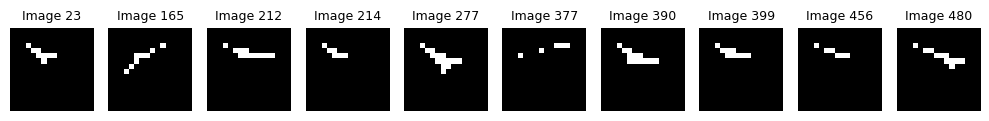

Estimating K-Score for Image 390: K-Score = 0.3333333333333333
Intersection sets : [ 62 277 390 462]
Union sets: [ 27  62  85 138 142 165 223 277 390 399 461 462]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   390                    1.000000                            0.718820
    27                    0.527525                            0.269711
    62                    0.732051                            0.613660
    85                    0.477098                            0.363779
   138                    0.178511                            0.575002
   142                    0.456986                            0.594955
   165                   -0.183503                            0.586991
   223                    0.527525                            0.540036
   277                    0.697337                            0.662263
   399                    0.732051                            0.416941
   461        

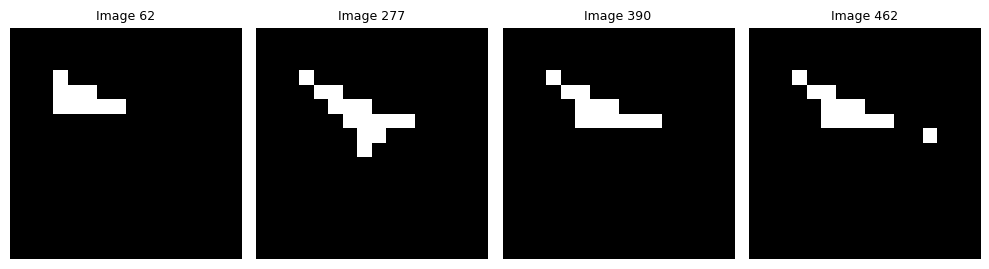


Plotting images in the union set:


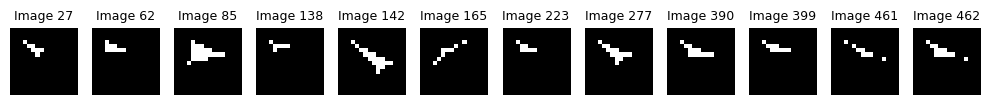


For translationally unique plots: 
Image 27 has no translationally similar images.
Image 62 has no translationally similar images.
Image 85 has no translationally similar images.
Image 138 has no translationally similar images.
Image 142 has no translationally similar images.
Image 165 has no translationally similar images.
Image 223 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 461 has no translationally similar images.
Image 462 has no translationally similar images.

Plotting images in the intersection set:


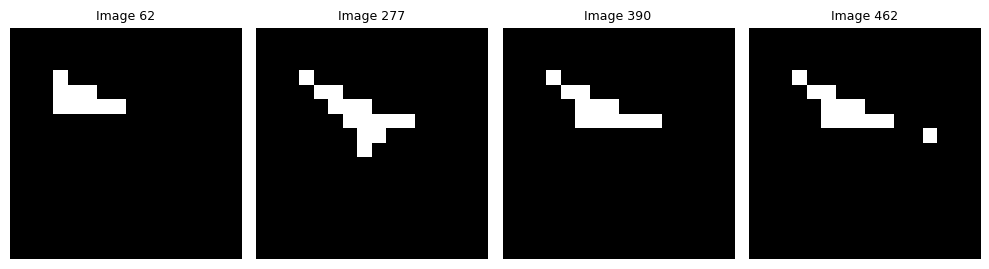


Plotting images in the union set:


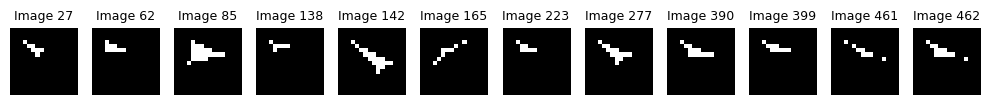

----------------
Transformed Normalised Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 399: K-Score = 0.6
Intersection sets : [ 23 212 390 399 456 480]
Union sets: [ 23 113 212 214 277 390 399 456 480 493]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   399                    1.000000                            1.000000
    23                    0.649916                            0.662182
   113                    0.539601                            0.570275
   212                    0.608060                            0.734409
   214                    0.632993                            0.450198
   277                    0.603567                            0.559436
   390                    0.732051                            0.608292
   456                    0.632993                            0.696729
   480                    0.608060                            0.644904
   493       

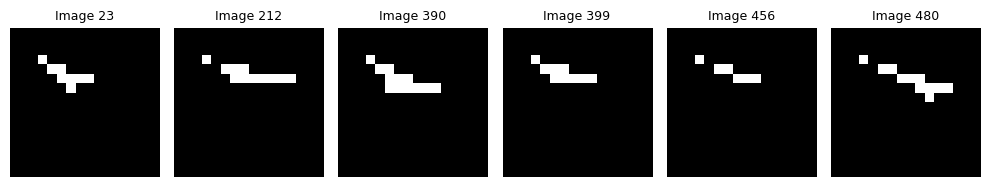


Plotting images in the union set:


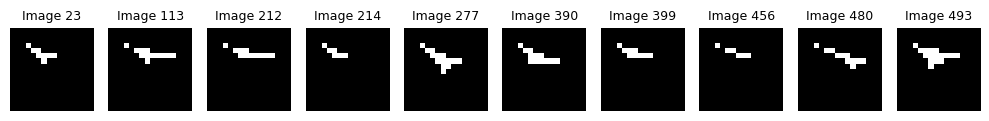


For translationally unique plots: 
Image 23 has no translationally similar images.
Image 113 has no translationally similar images.
Image 212 has no translationally similar images.
Image 214 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 456 has no translationally similar images.
Image 480 has no translationally similar images.
Image 493 has no translationally similar images.

Plotting images in the intersection set:


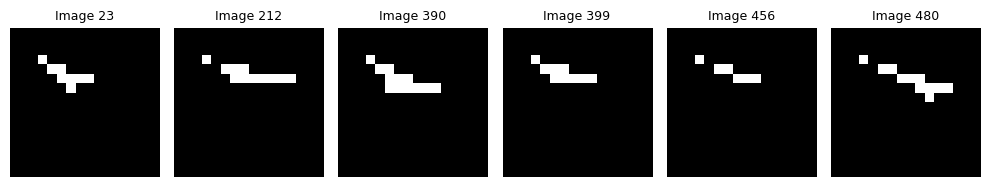


Plotting images in the union set:


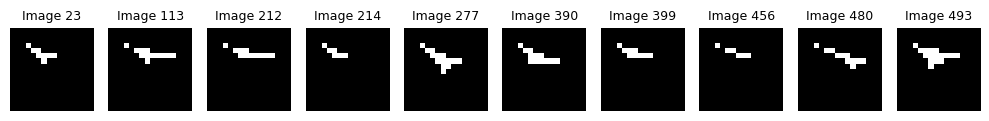

Estimating K-Score for Image 390: K-Score = 0.6
Intersection sets : [ 62 223 277 390 399 462]
Union sets: [ 27  62  85 142 223 277 390 399 461 462]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   390                    1.000000                            1.000000
    27                    0.527525                            0.315010
    62                    0.732051                            0.739769
    85                    0.477098                            0.474300
   142                    0.456986                            0.743675
   223                    0.527525                            0.570313
   277                    0.697337                            0.711140
   399                    0.732051                            0.608292
   461                    0.428869                            0.610804
   462                    0.833333                            0.888665

Comparing images in intersec

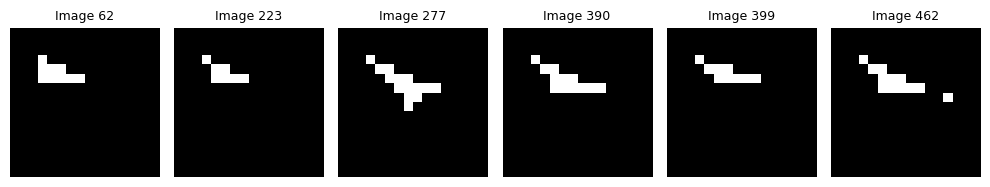


Plotting images in the union set:


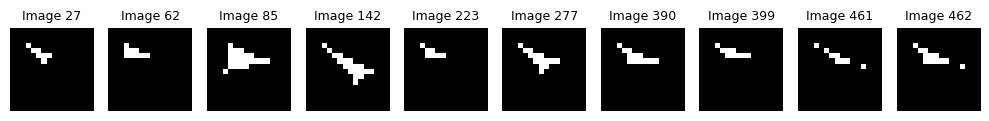


For translationally unique plots: 
Image 27 has no translationally similar images.
Image 62 has no translationally similar images.
Image 85 has no translationally similar images.
Image 142 has no translationally similar images.
Image 223 has no translationally similar images.
Image 277 has no translationally similar images.
Image 390 has no translationally similar images.
Image 399 has no translationally similar images.
Image 461 has no translationally similar images.
Image 462 has no translationally similar images.

Plotting images in the intersection set:


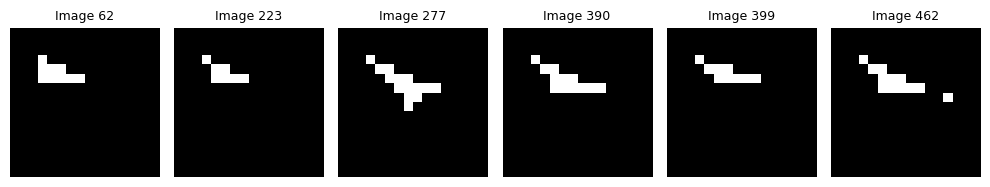


Plotting images in the union set:


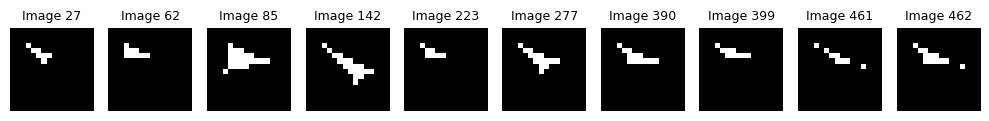

(array([ 62, 223, 277, 390, 399, 462]),
 [27, 62, 85, 142, 223, 277, 390, 399, 461, 462])

In [10]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)

print("----------------\nTransformed Model Method -- KNN-IOU score\n----------------")
input2_transformed_1 =  model_transformed[index1]
input2_transformed_2 =  model_transformed[index2]
vectorc_transformed_1 = []
vectorc_transformed_2 = []
for j in range(len(input_dataset)):
    input1_transformed =  model_transformed[j]
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_1, dim=1)
    vectorc_transformed_1.append(dot_product_transformed.detach().cpu().numpy().item())
    
    dot_product_transformed = torch.sum(input1_transformed * input2_transformed_2, dim=1)
    vectorc_transformed_2.append(dot_product_transformed.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_2, "Model", index2, k, testSample)

print("----------------\nTransformed Normalised Model Method -- KNN-IOU score\n----------------")
input2_transformed_normalised_1 =  model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
input2_transformed_normalised_2 =  model_transformed[index2]/np.linalg.norm(model_transformed[index2].detach().cpu().numpy())
vectorc_transformed_normalised_1 = []
vectorc_transformed_normalised_2 = []
for j in range(len(input_dataset)):
    input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_1, dim=1)
    vectorc_transformed_normalised_1.append(dot_product_transformed_normalised.detach().cpu().numpy().item())
    
    dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised_2, dim=1)
    vectorc_transformed_normalised_2.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

imgplt.display_and_plot_results(vectorb_model1, vectorc_transformed_normalised_1, "Model", index1, k, testSample)
imgplt.display_and_plot_results(vectorb_model2, vectorc_transformed_normalised_2, "Model", index2, k, testSample)

### Visualisation of Relative Squared Difference of **original** matrix and vector embedding -- Metric 3

In [ ]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Matrices -- Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of of Matrices -- Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of of Matrices -- Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of Relative Squared Difference of **transformed** matrix and vector embedding using Orthogonal Procrustes -- Metric 3

In [7]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Matrices -- Transformed Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Matrices -- Transformed Model and Pencorr (A'A):", mean_squared_difference)

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Transformed Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

Difference between matrices

Mean Squared Difference of Model and NCC (G): 1.5068431908935553
Mean Squared Difference of Model and Pencorr (A'A): 1.447351941599006
Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.3230924922125886

Printing matrices after transformation

Matrix G: [[ 1.         -0.65184468 -0.47018713 ... -0.75520396 -0.64365166
  -0.61025807]
 [-0.65184468  1.         -0.30828559 ... -0.16903645  0.2561537
   0.15337098]
 [-0.47018713 -0.30828559  1.         ... -0.51363957  0.27438617
  -0.53539678]
 ...
 [-0.75520396 -0.16903645 -0.51363957 ...  1.         -0.08405721
  -0.09363103]
 [-0.64365166  0.2561537   0.27438617 ... -0.08405721  1.
  -0.13197589]
 [-0.61025807  0.15337098 -0.53539678 ... -0.09363103 -0.13197589
   1.        ]]

Matrix A'A (Pencorr): [[ 1.         -0.40385153  0.17631002 ... -0.42973586 -0.42813806
  -0.22991002]
 [-0.40385153  1.         -0.15187719 ... -0.10746696  0.31210782
   0.22254778]
 [ 0.17631002 -0.15187719  1.         ... -0

ValueError: operands could not be broadcast together with shapes (500,) (64,) 

### Visualisation of Relative Squared Difference of **transformed normalised** vector embedding using Orthogonal Procrustes -- Metric 3

In [ ]:
#-----------------After normalising the transformed output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Transformed Normalised Model: {model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy())}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1]/np.linalg.norm(model_transformed[index1].detach().cpu().numpy()))
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Normalised Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Transformed Model: {mean_squared_difference}")

mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

### Visualisation of original vector embeddings of similar images across dimensions -- Metric 4

For dimension 32
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


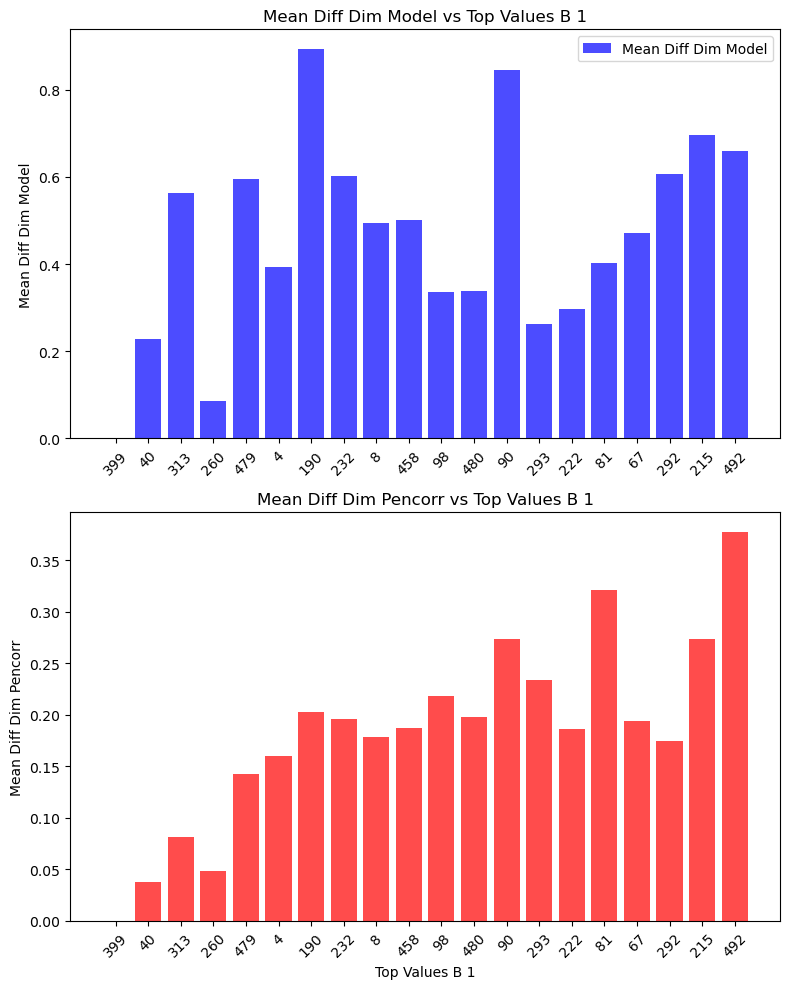

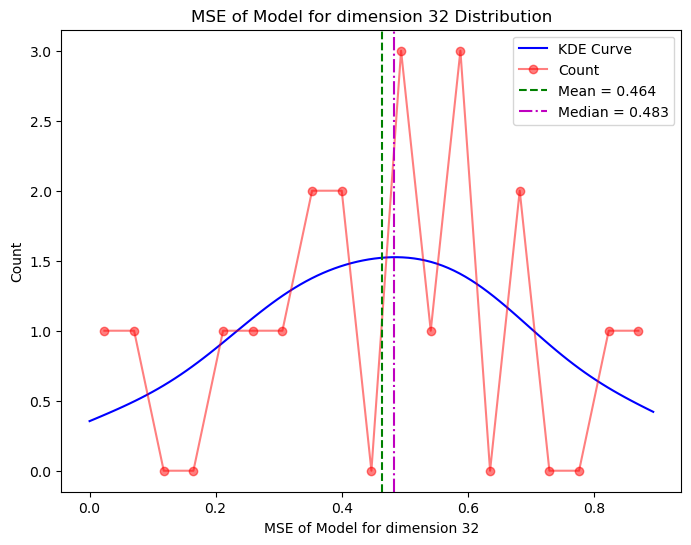

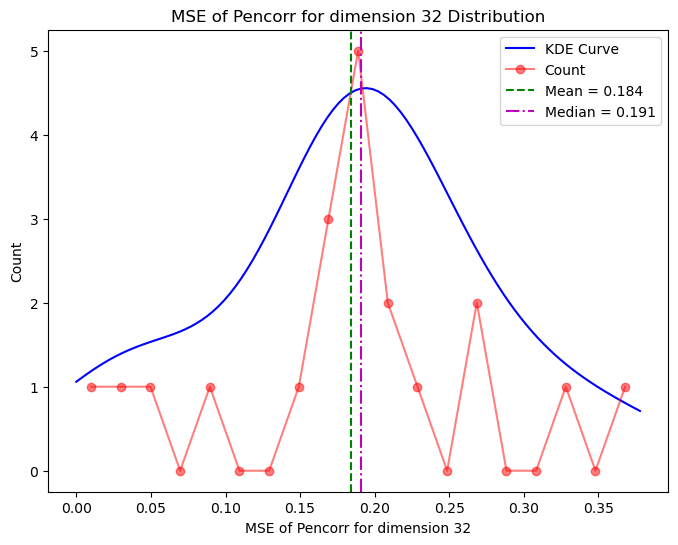

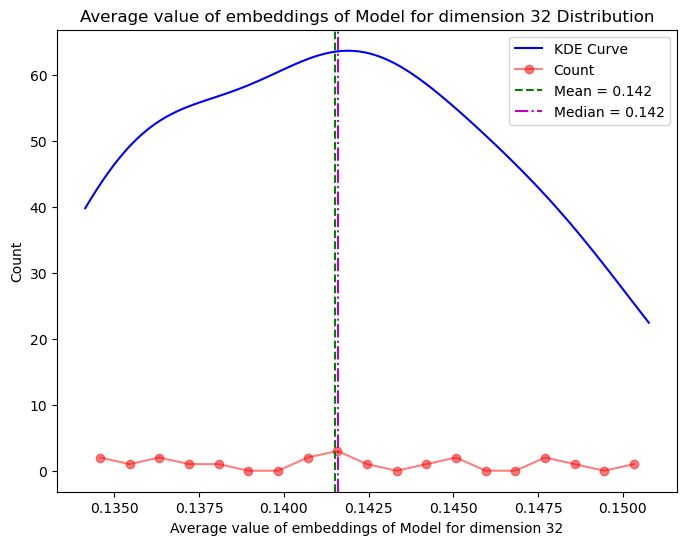

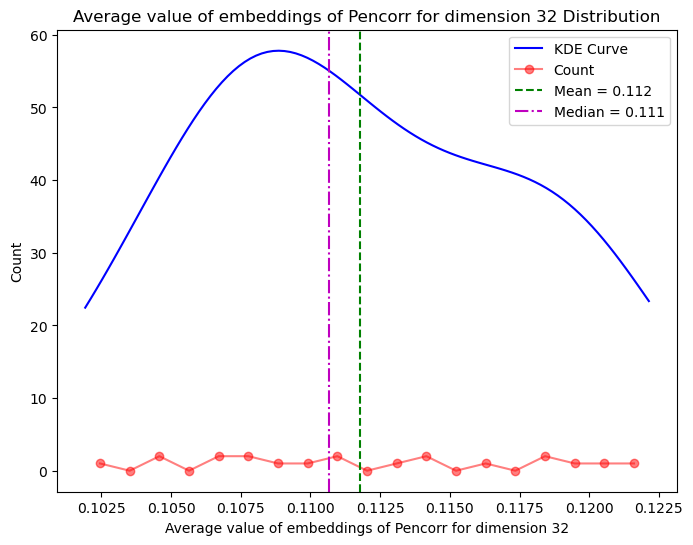

For dimension 64
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


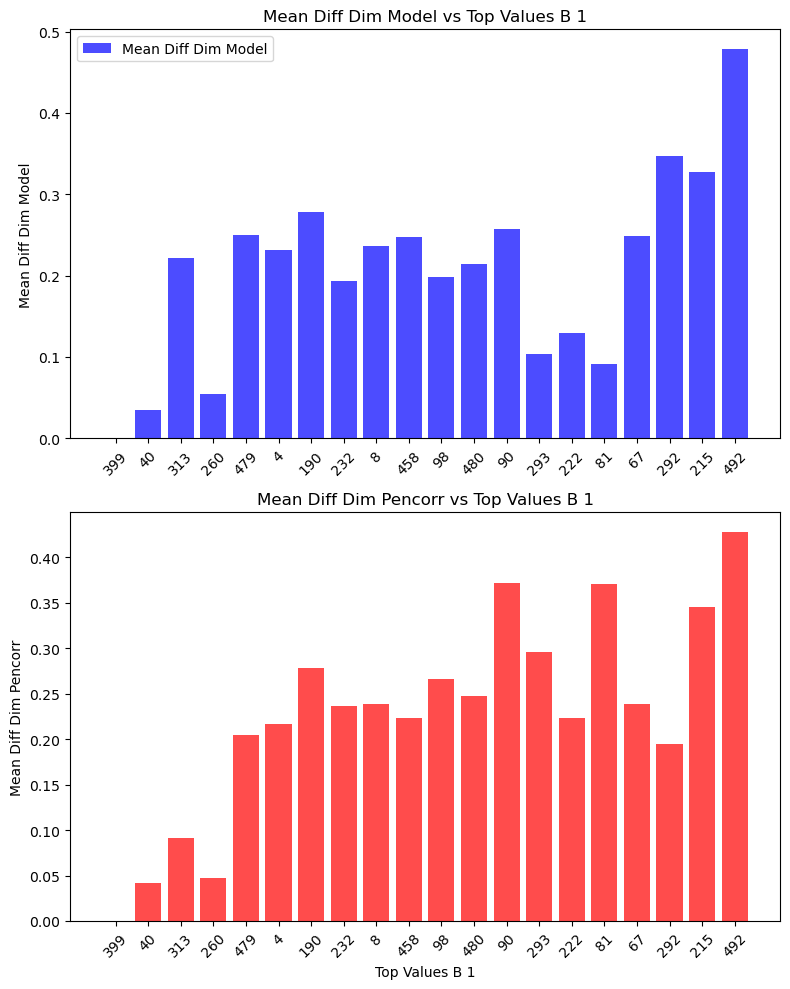

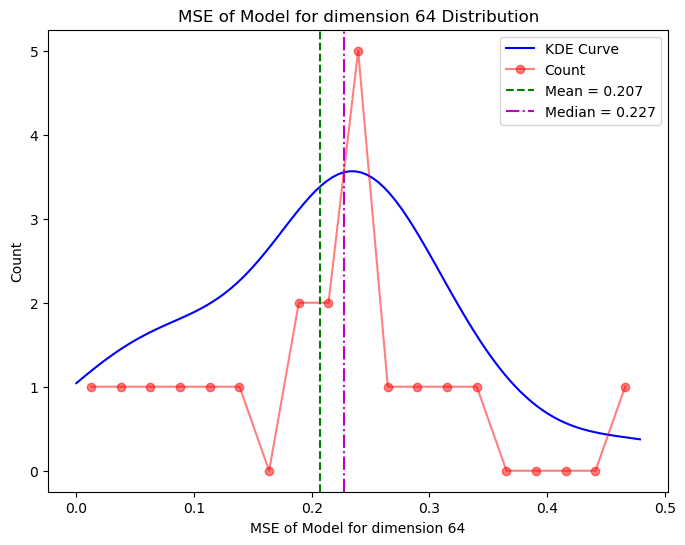

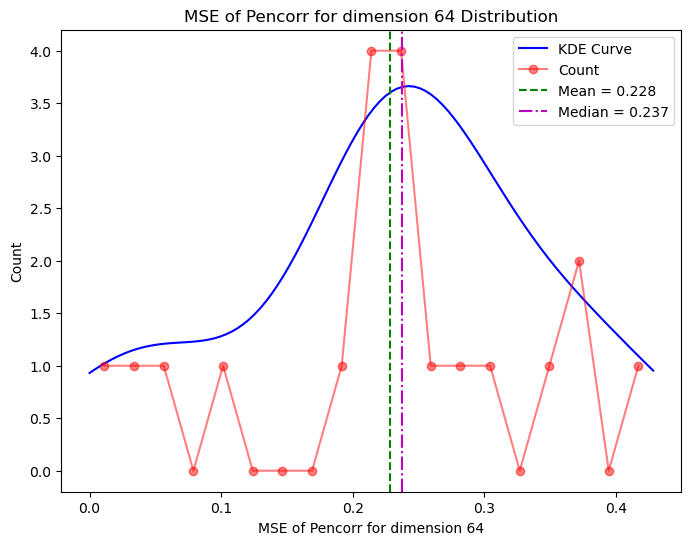

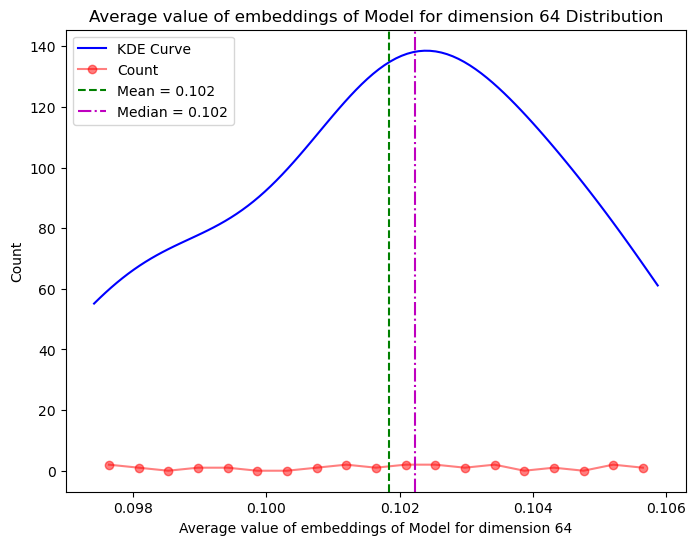

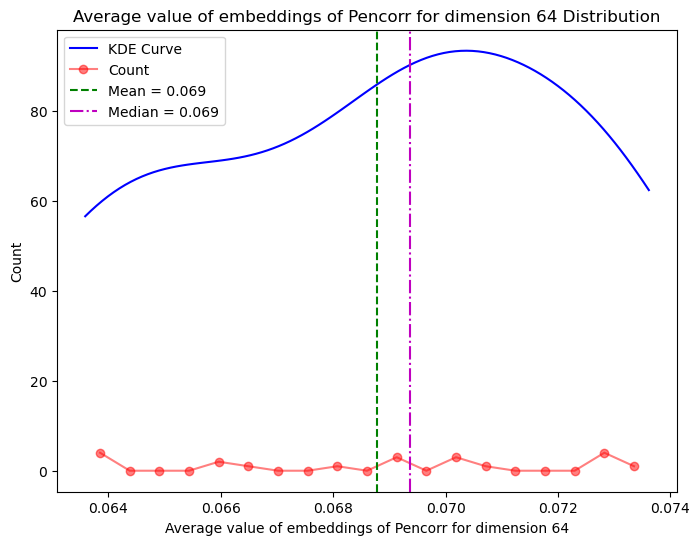

For dimension 128
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


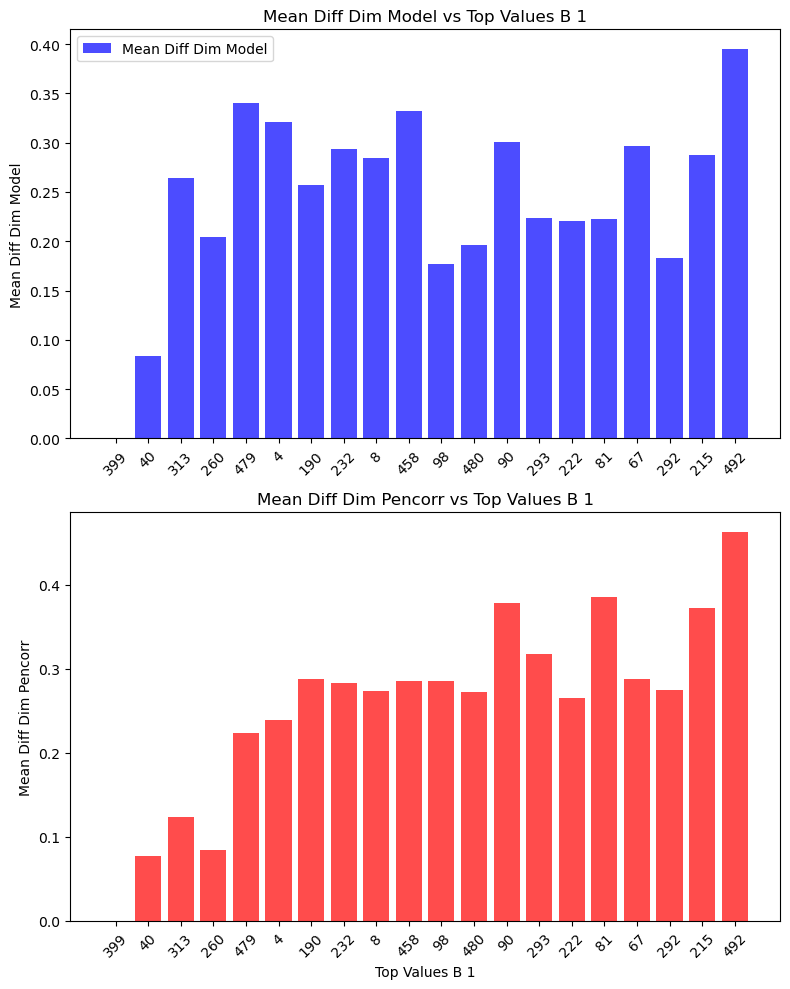

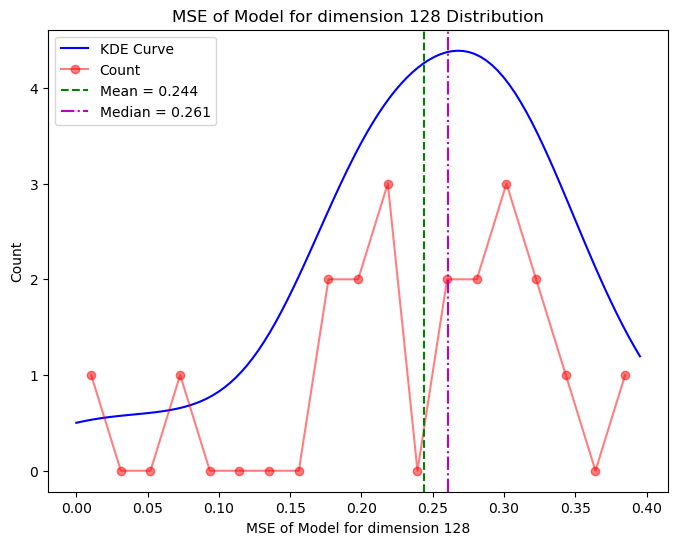

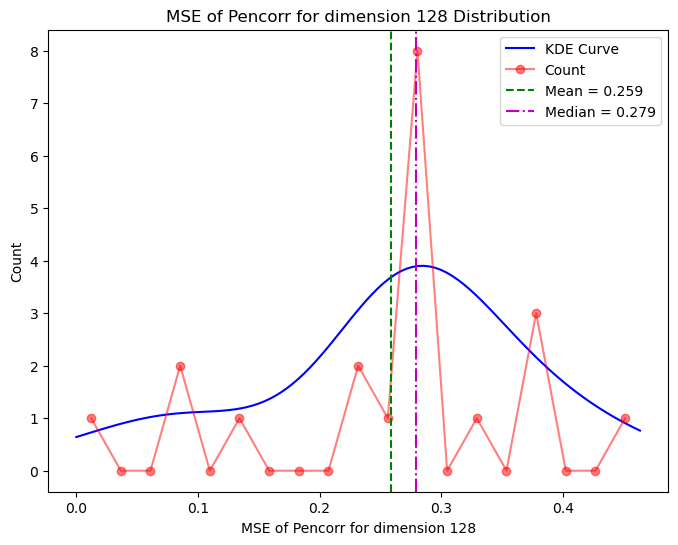

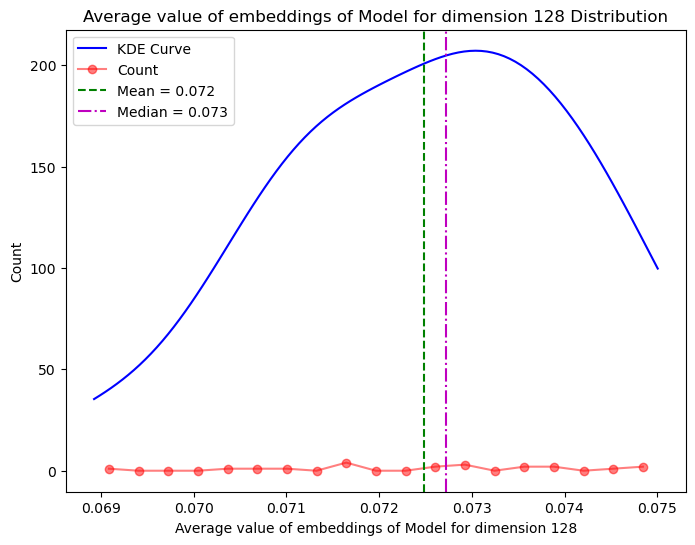

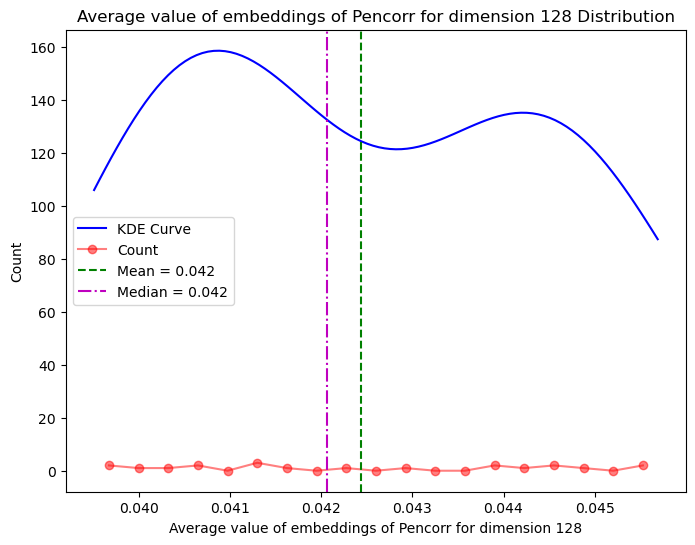

For dimension 256
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


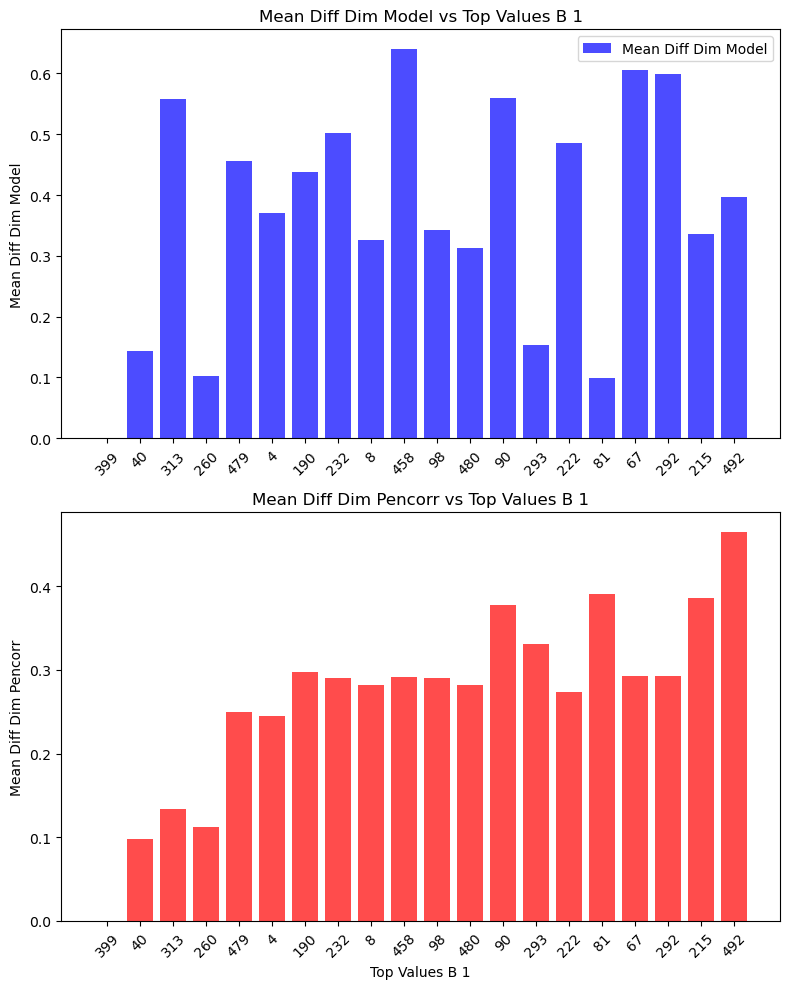

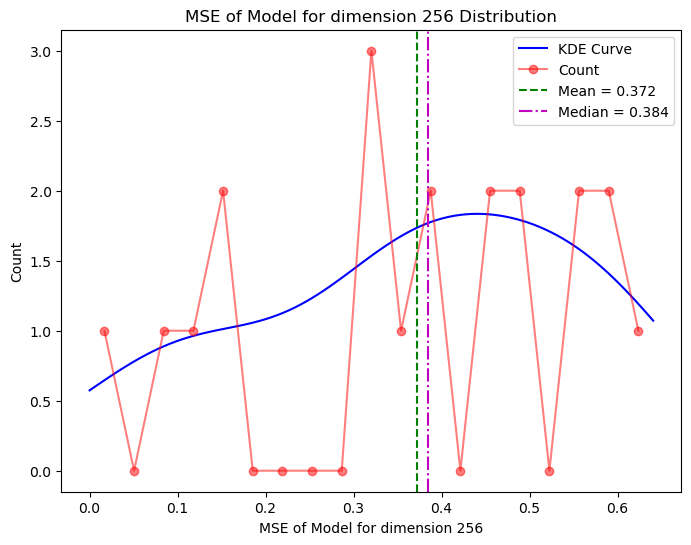

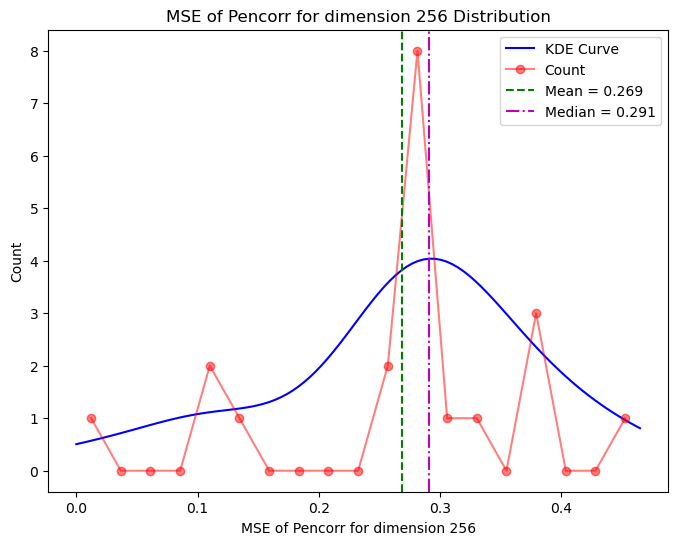

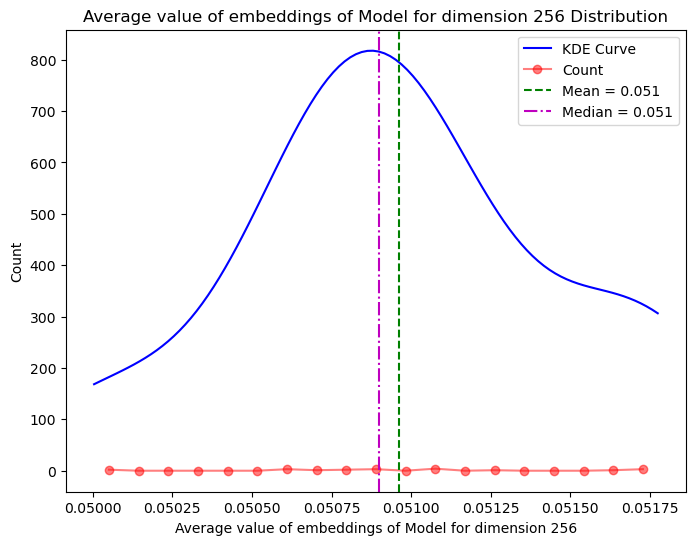

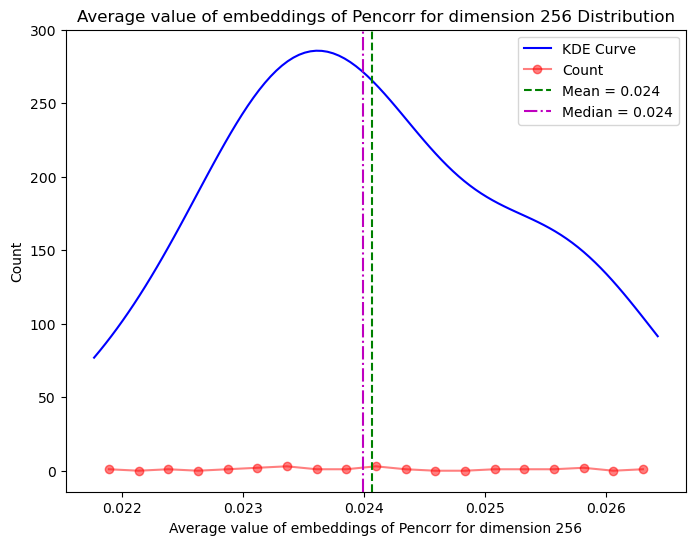

In [11]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

### Visualisation of original vector embeddings of different images across dimensions -- Metric 4

For dimension 32


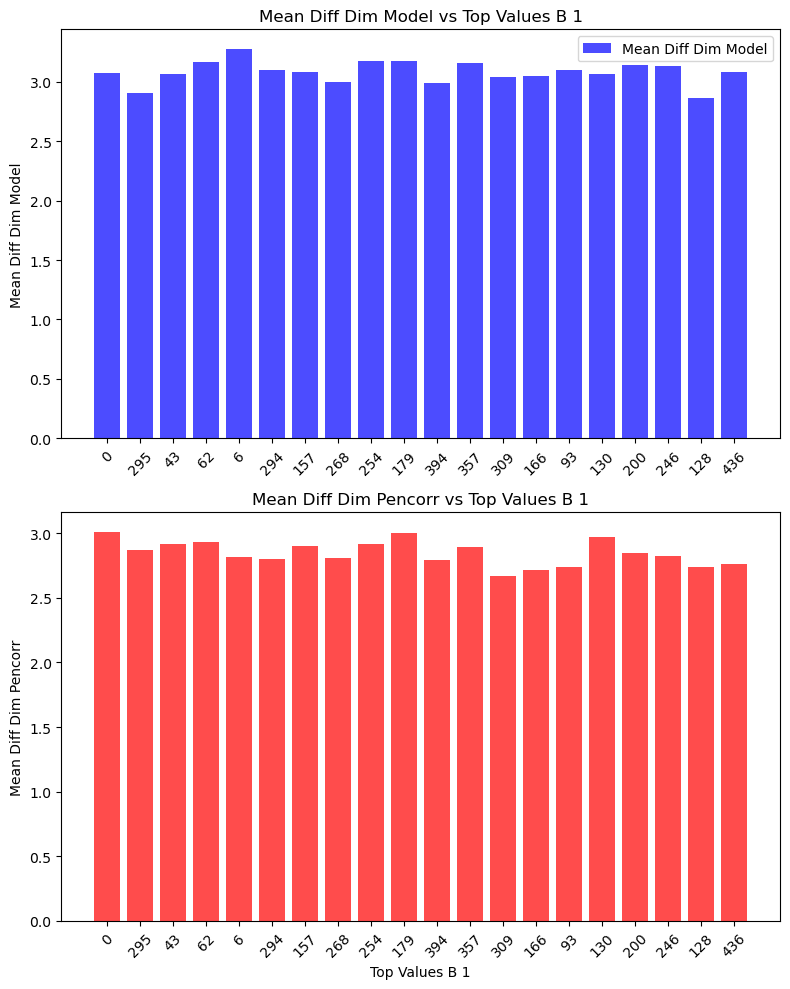

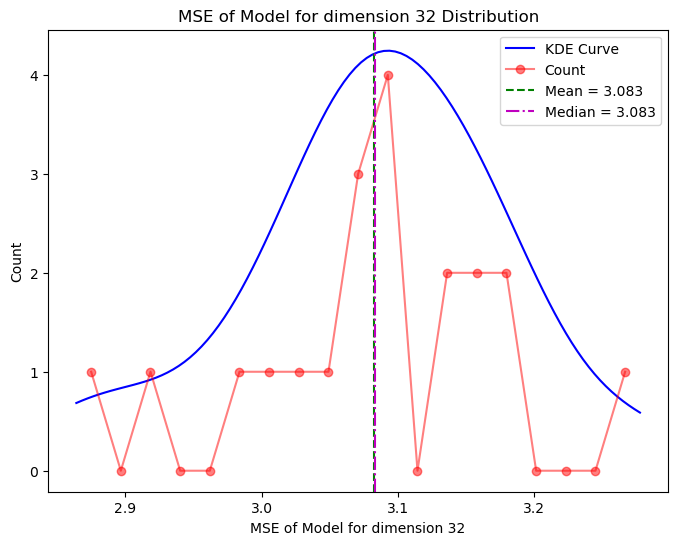

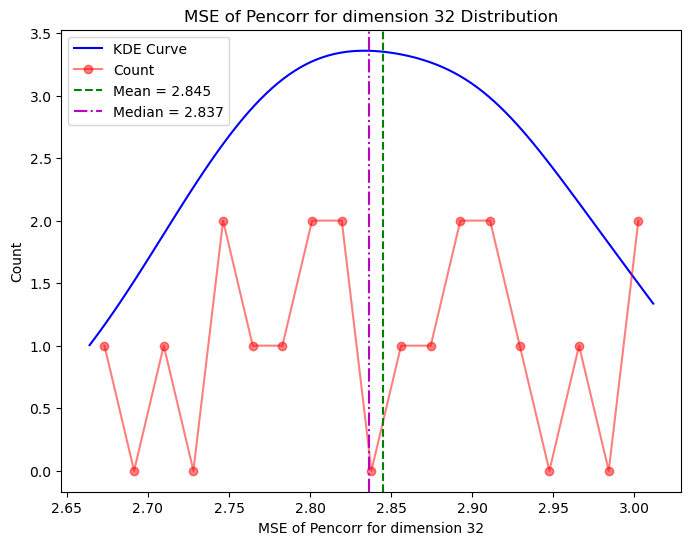

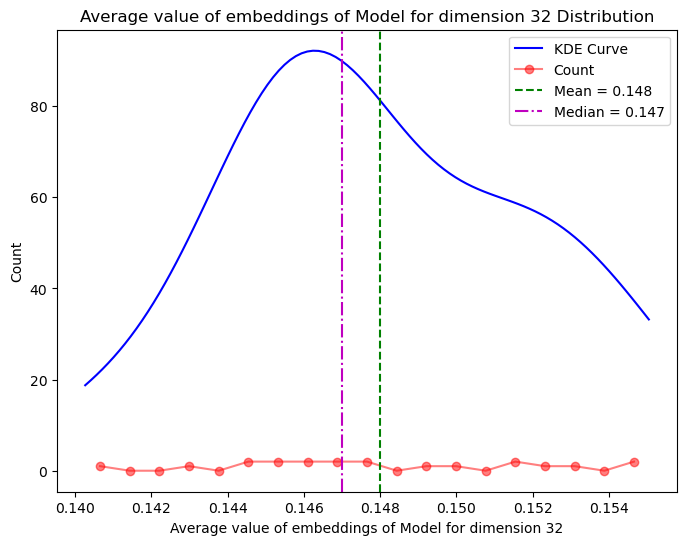

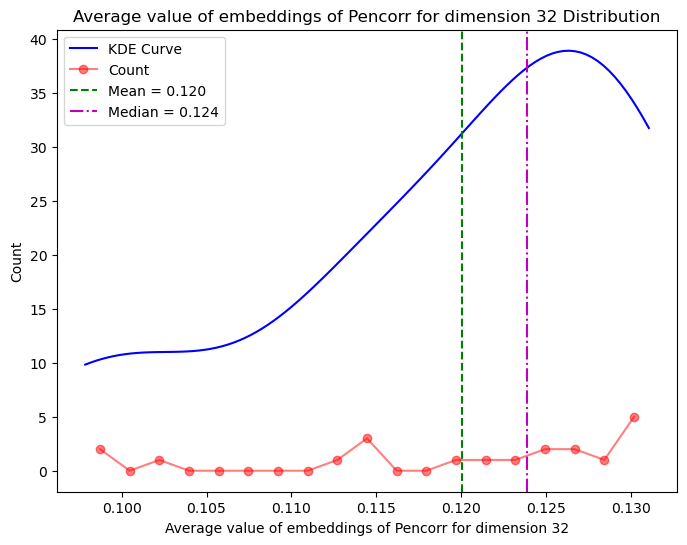

For dimension 64


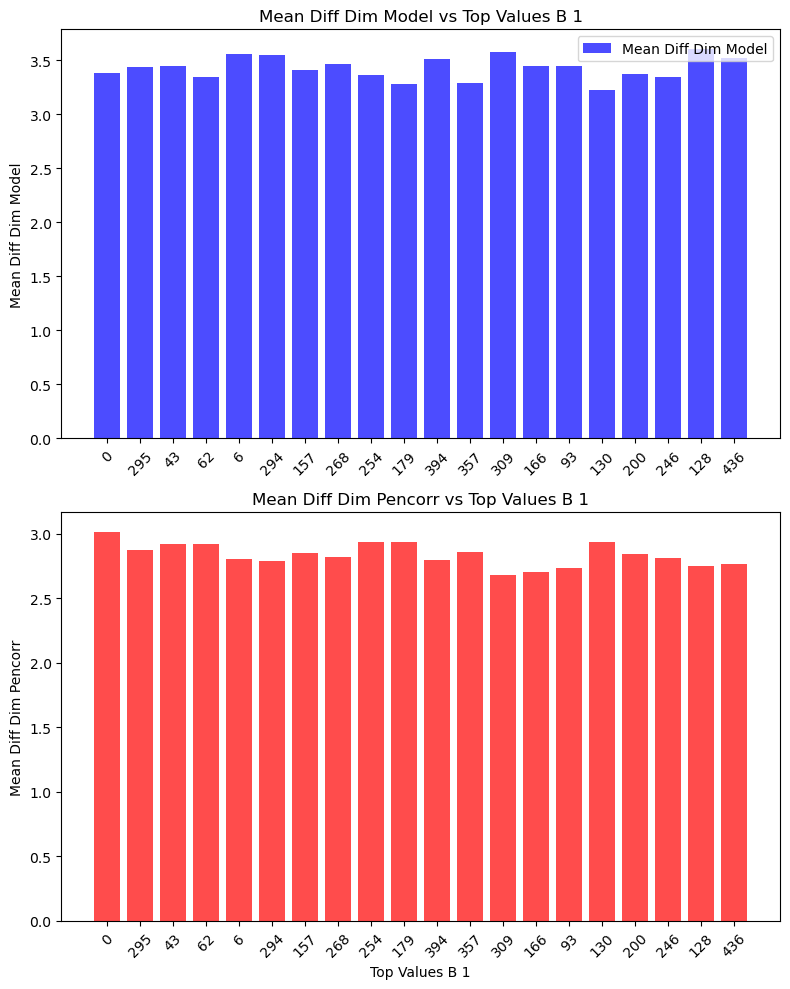

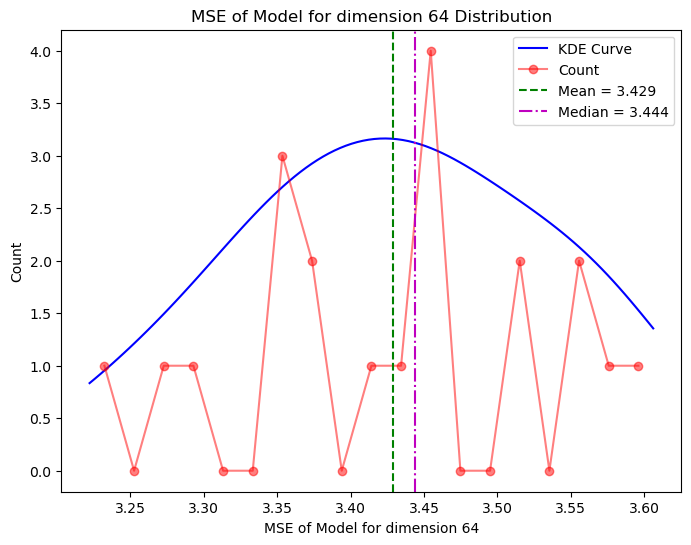

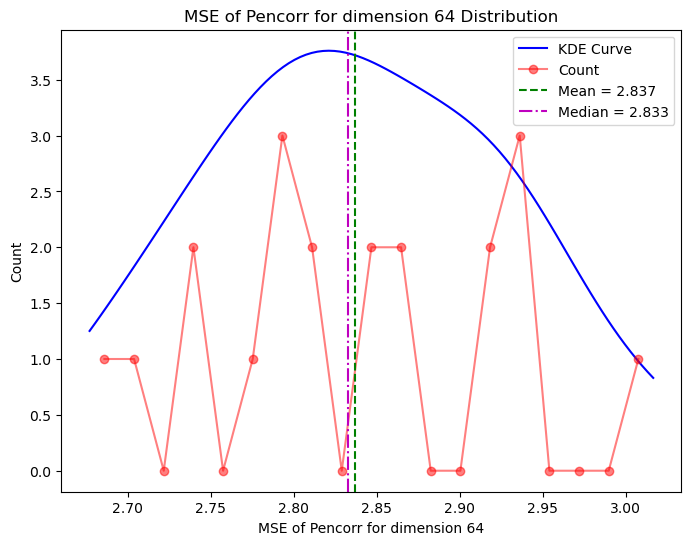

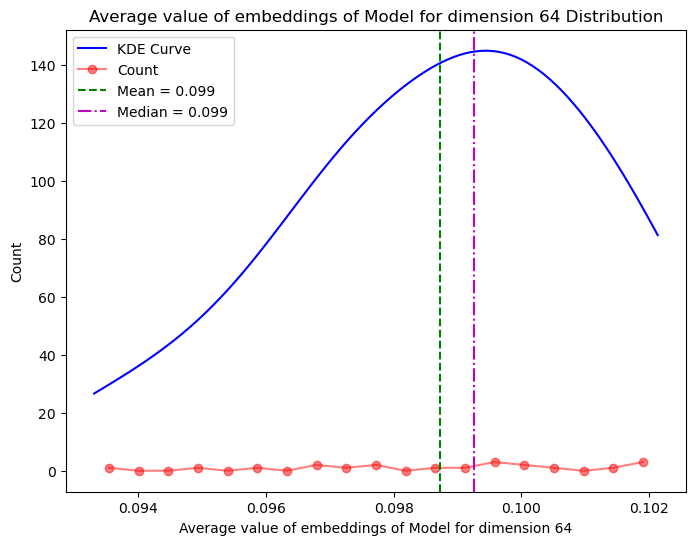

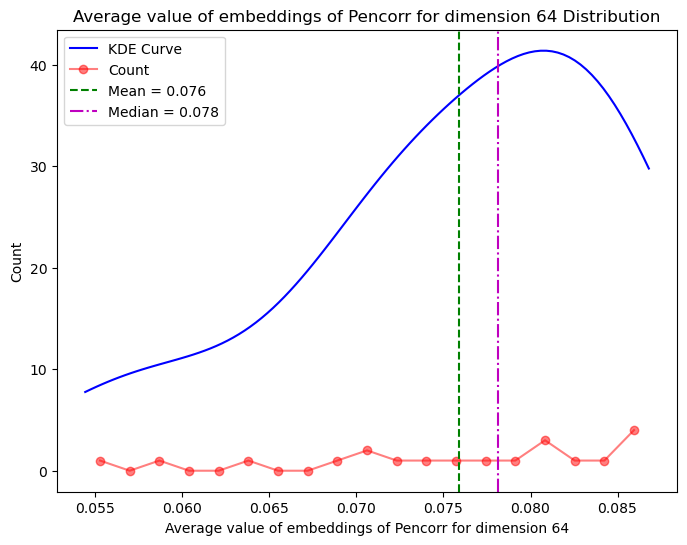

For dimension 128


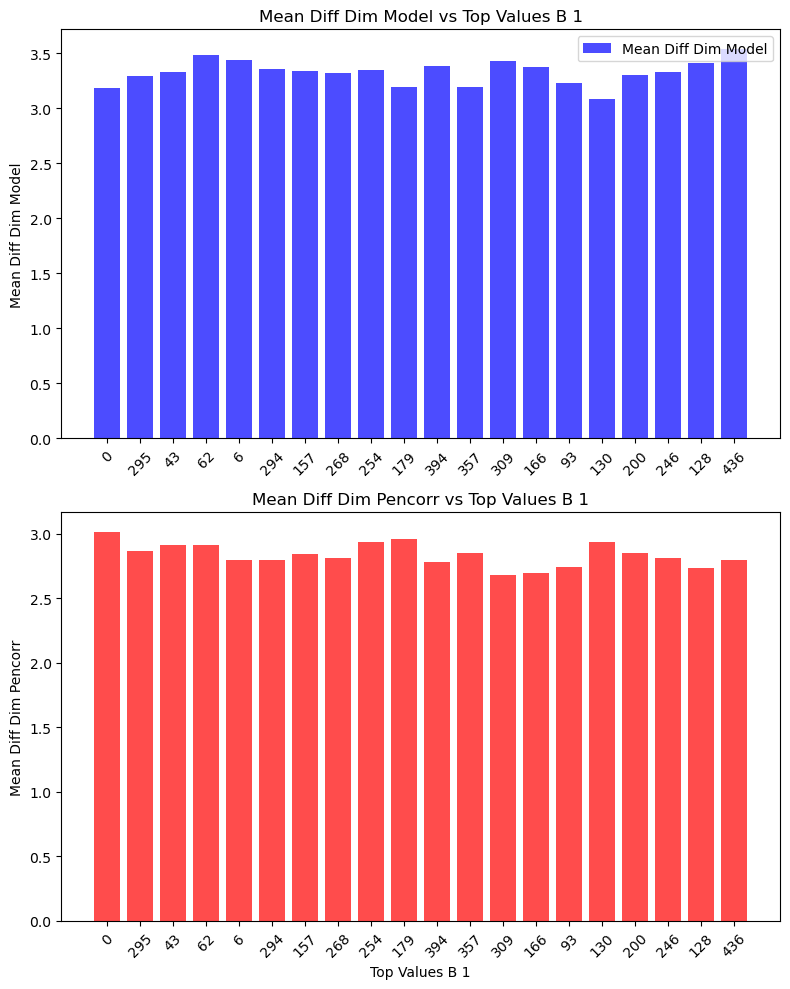

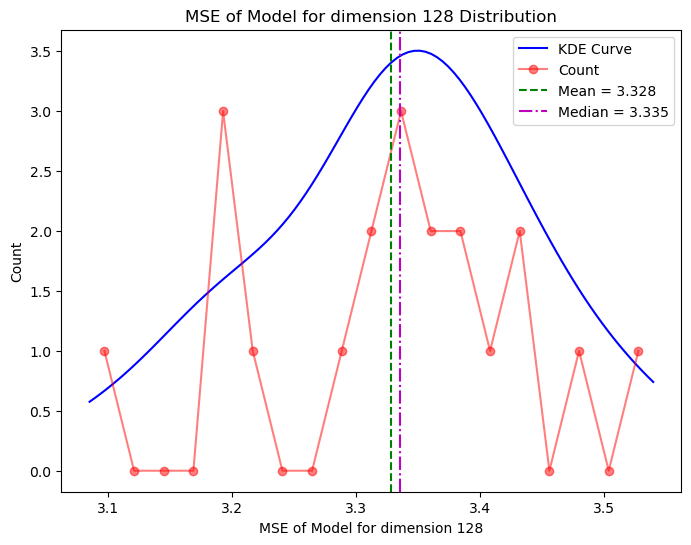

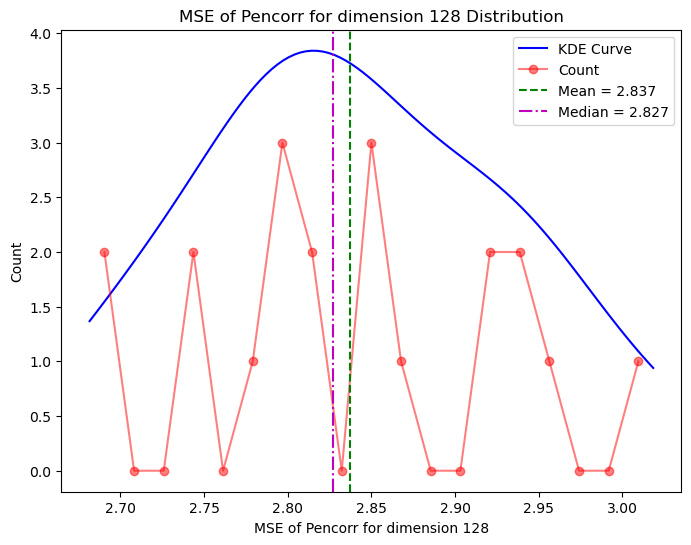

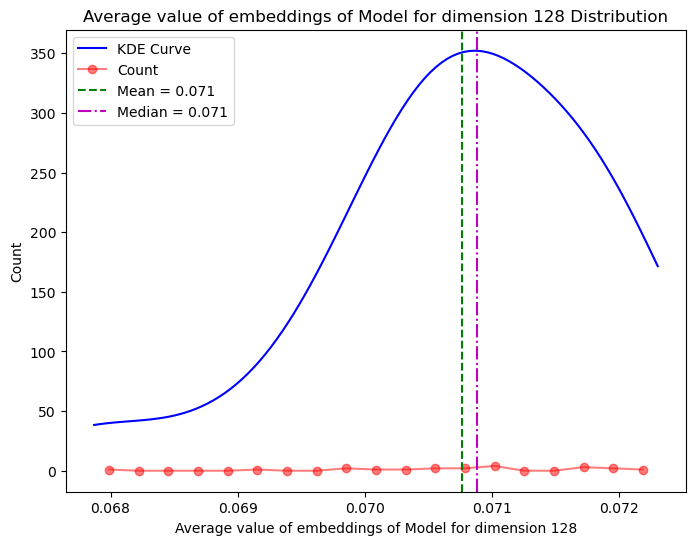

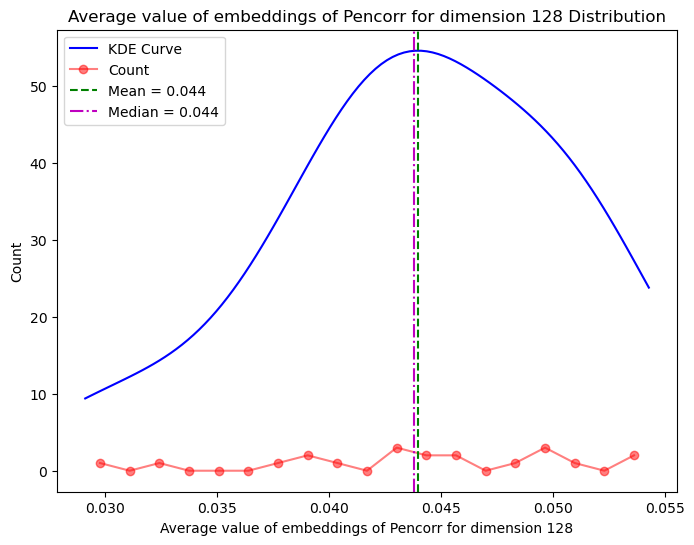

For dimension 256


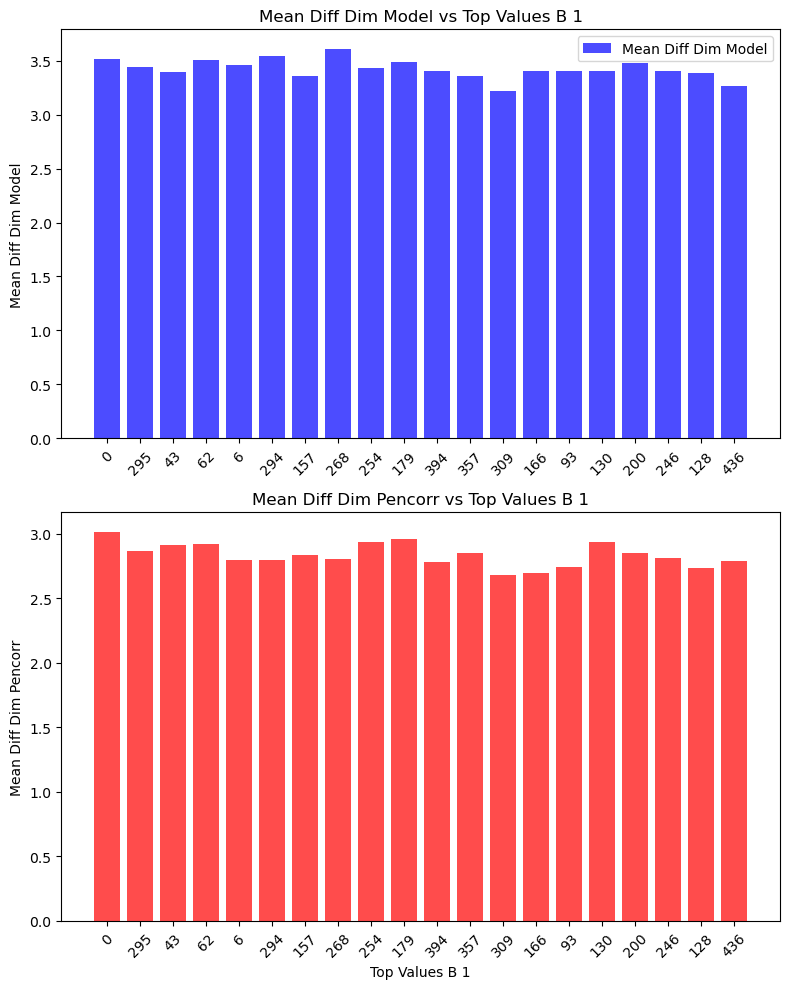

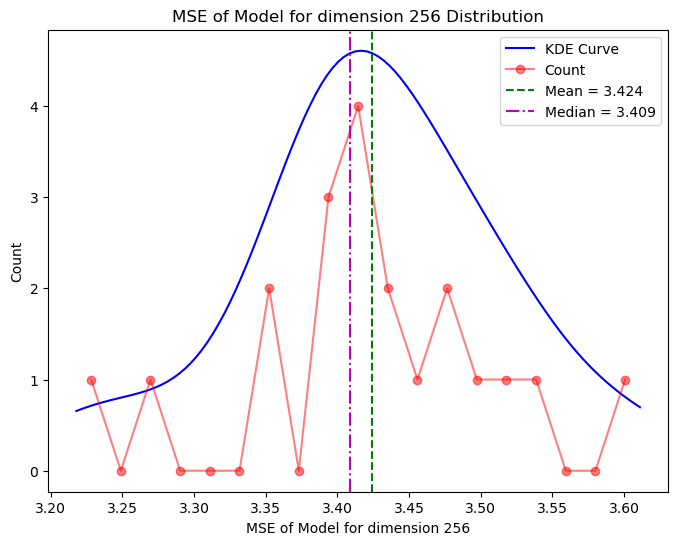

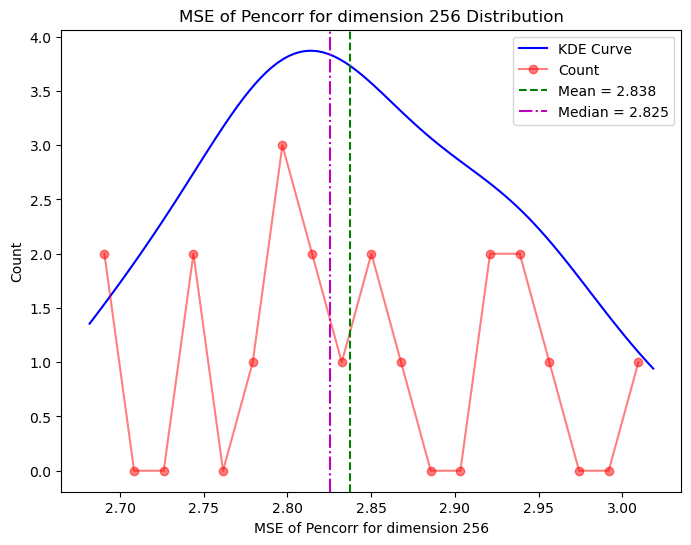

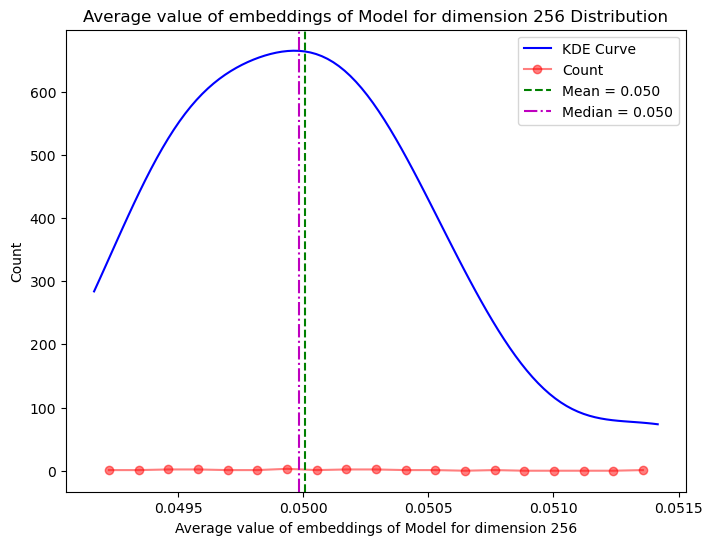

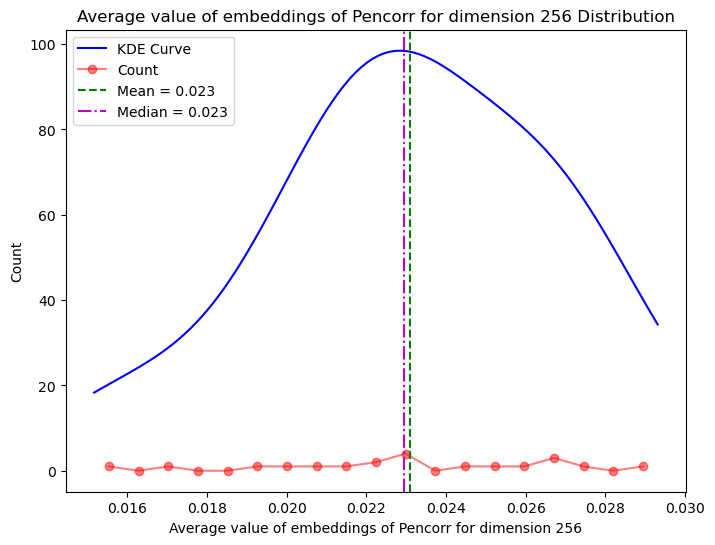

In [12]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

# Visualiation and Calculation across dataset, across dimensions

## Metric 1 & 2: Loss and K-Score
### Visualisation of loss and k-score across dataset across dimensions

For dimension 8


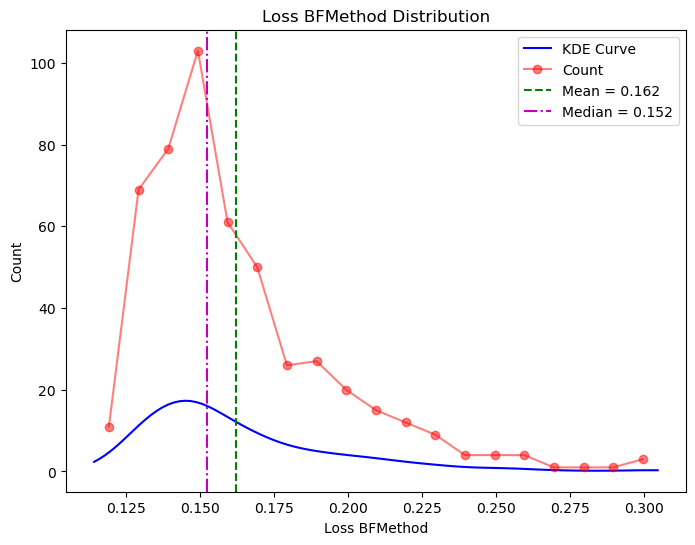

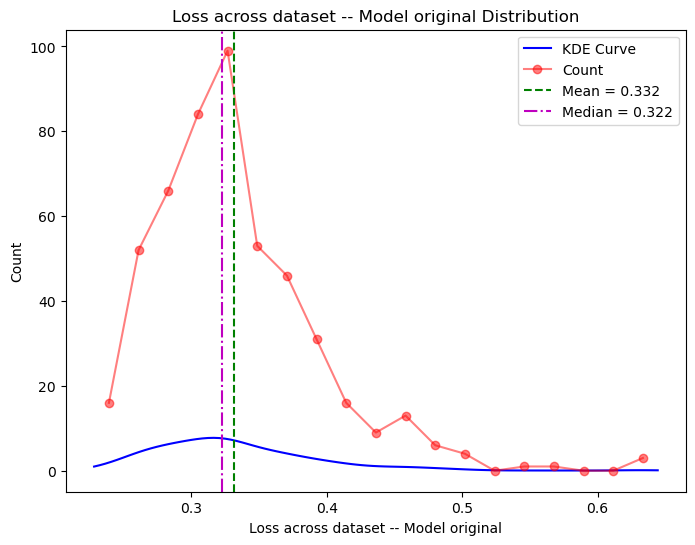

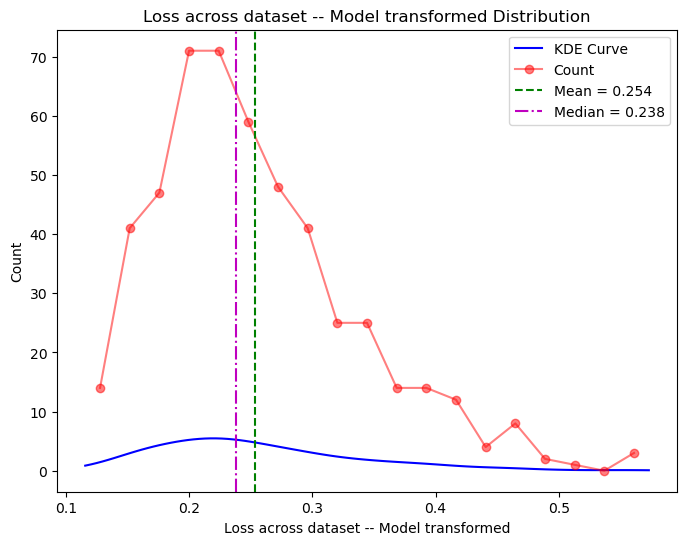

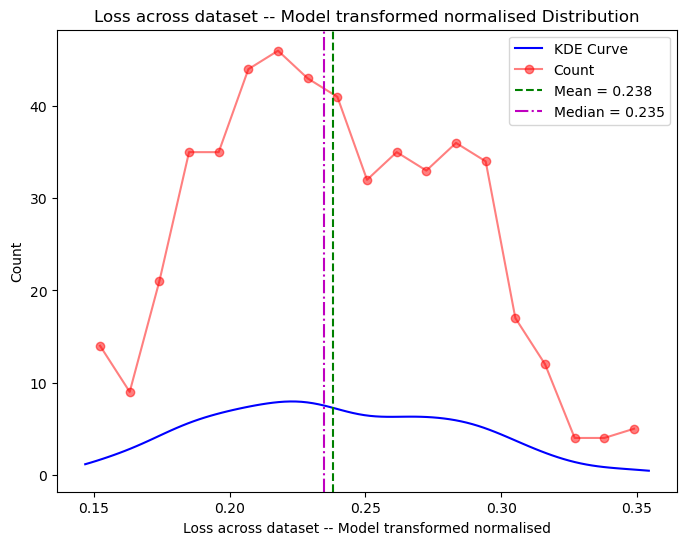

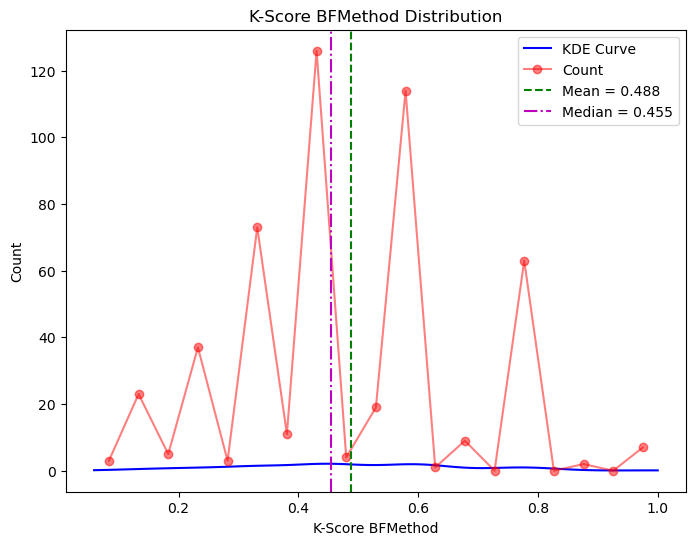

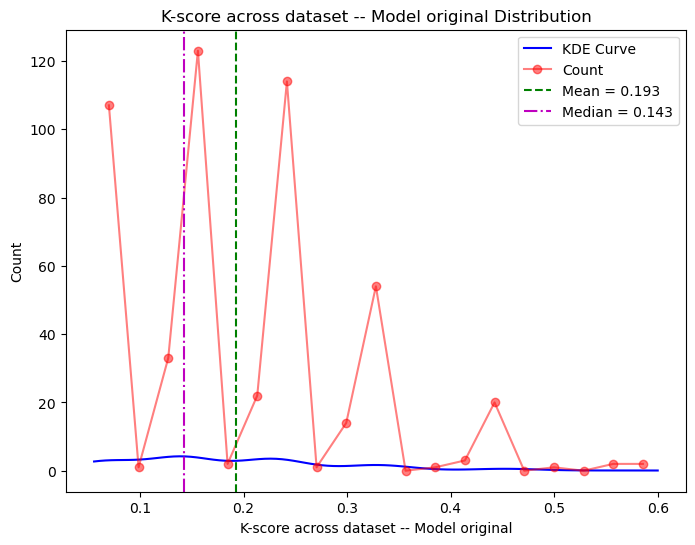

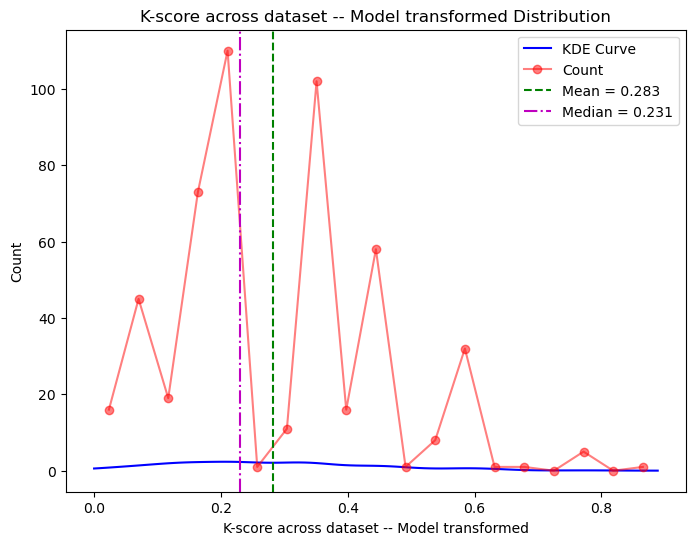

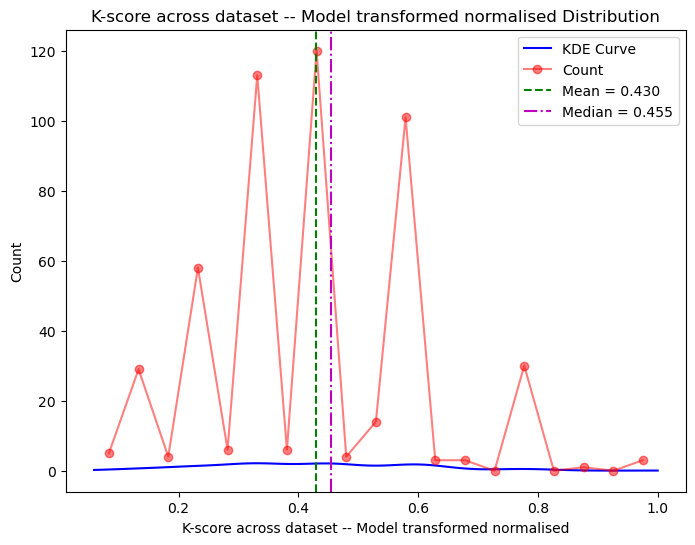

For dimension 16


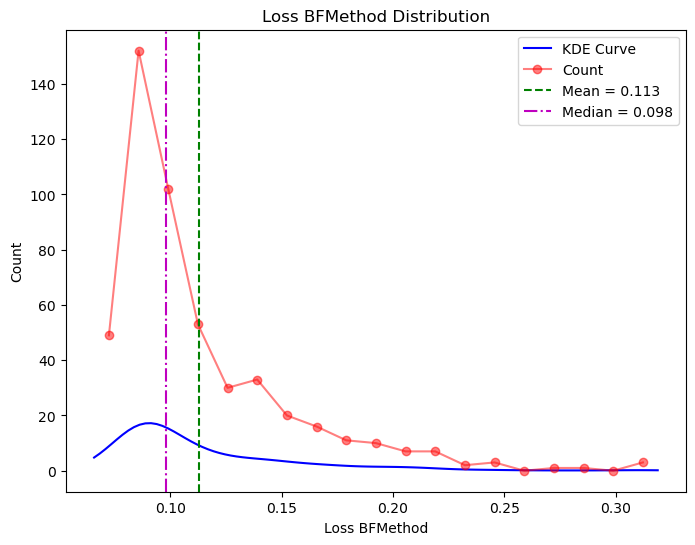

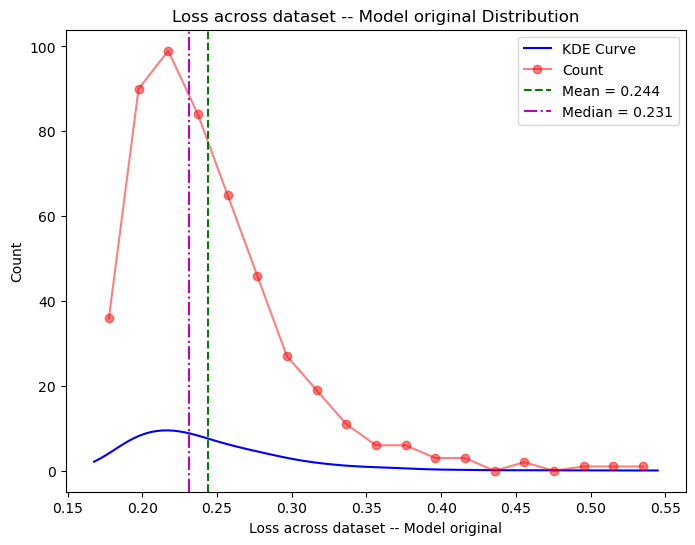

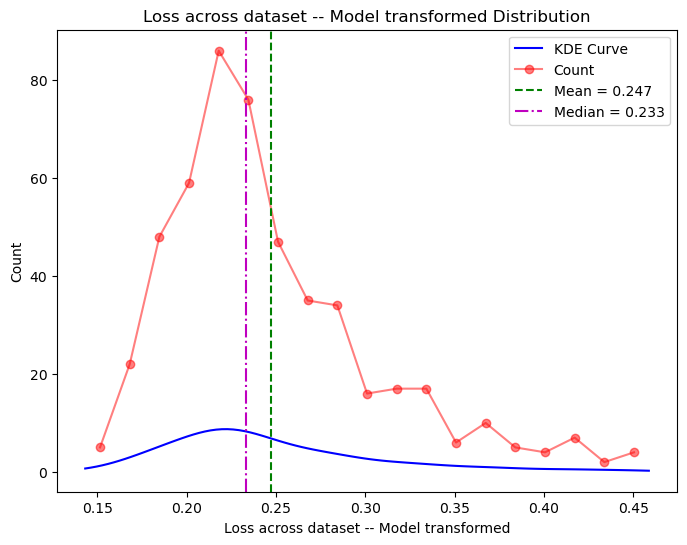

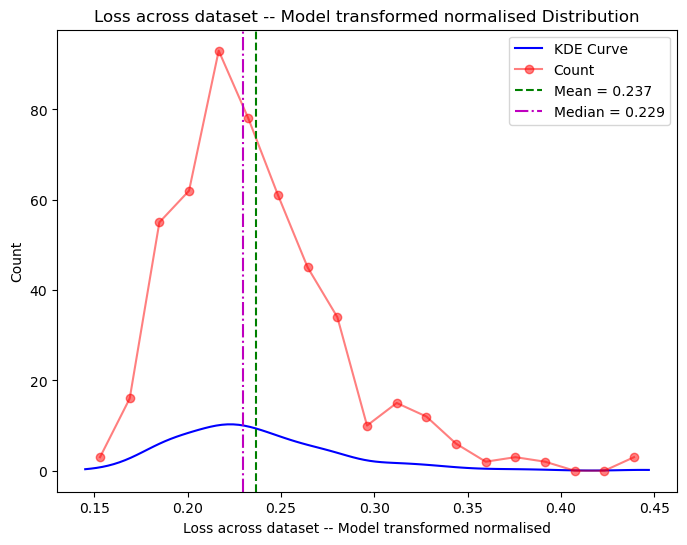

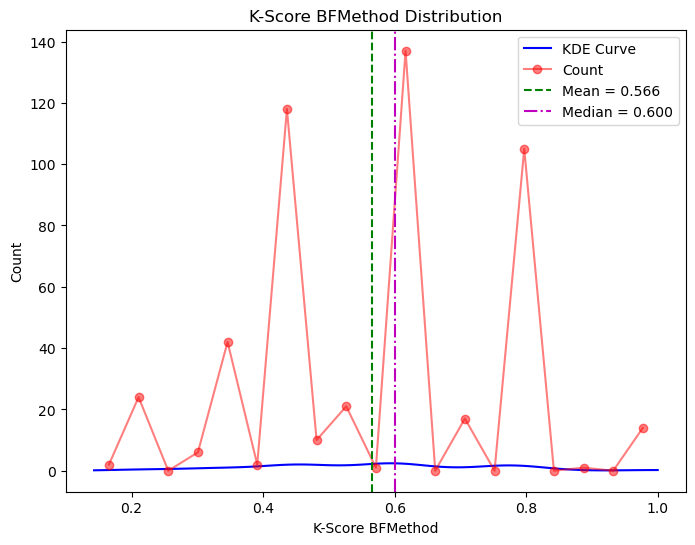

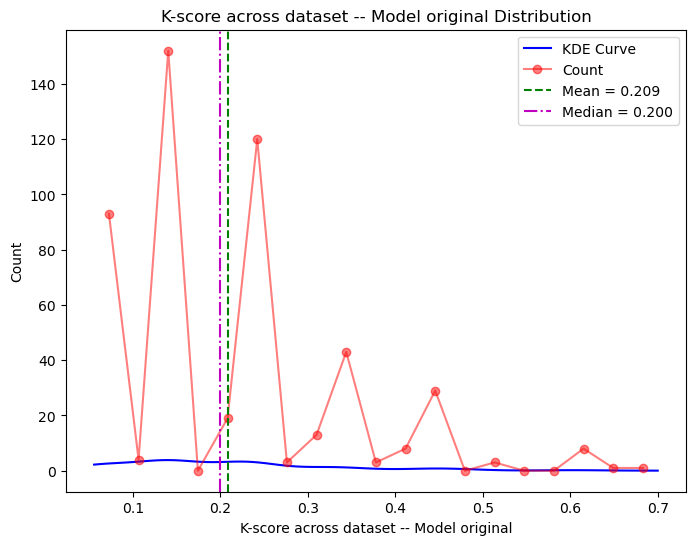

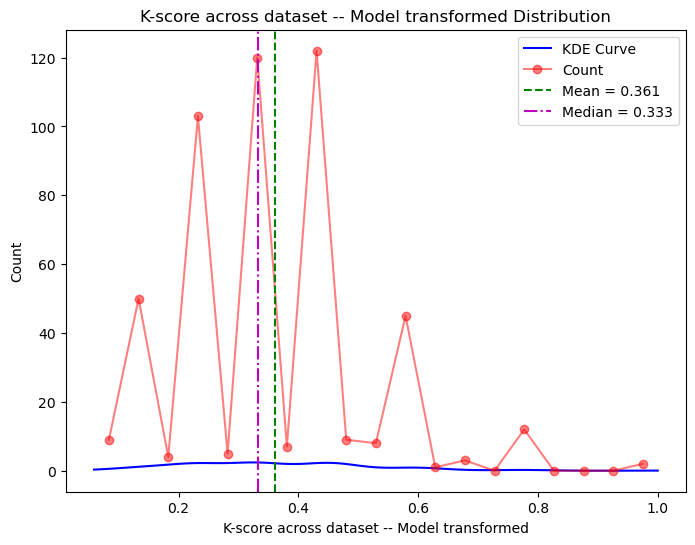

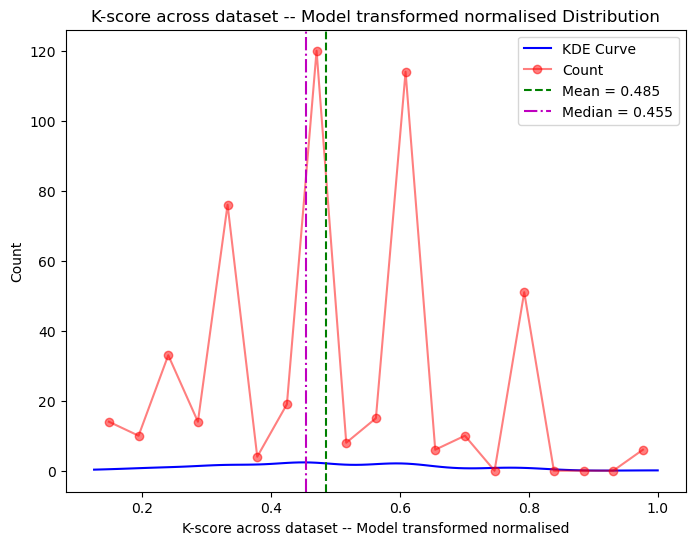

For dimension 32


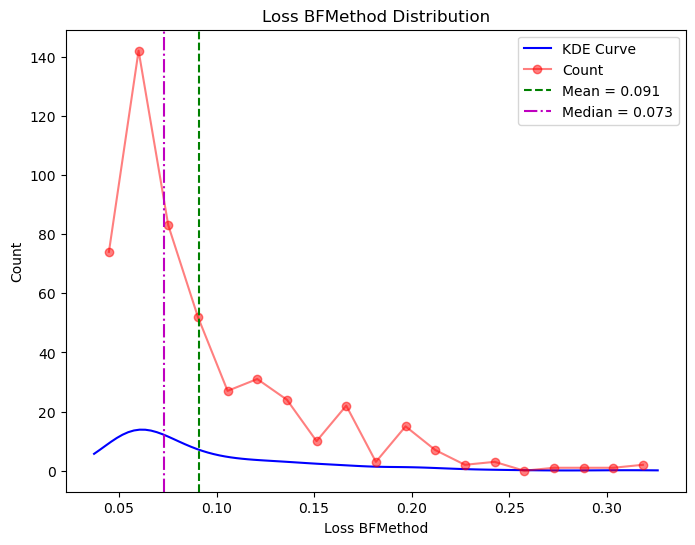

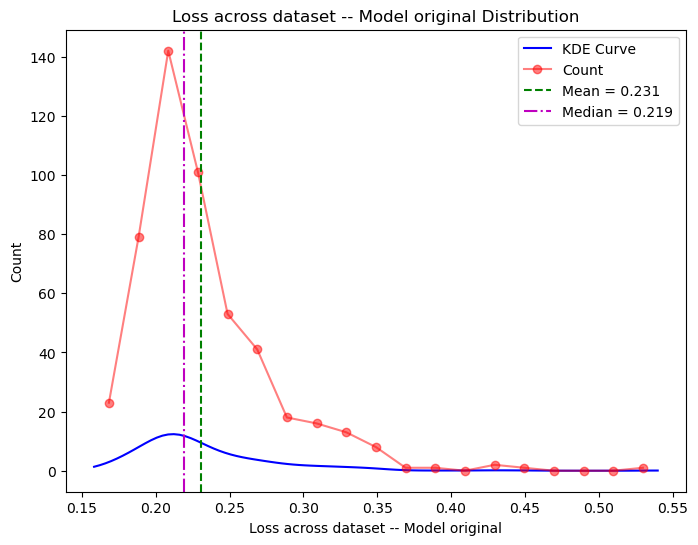

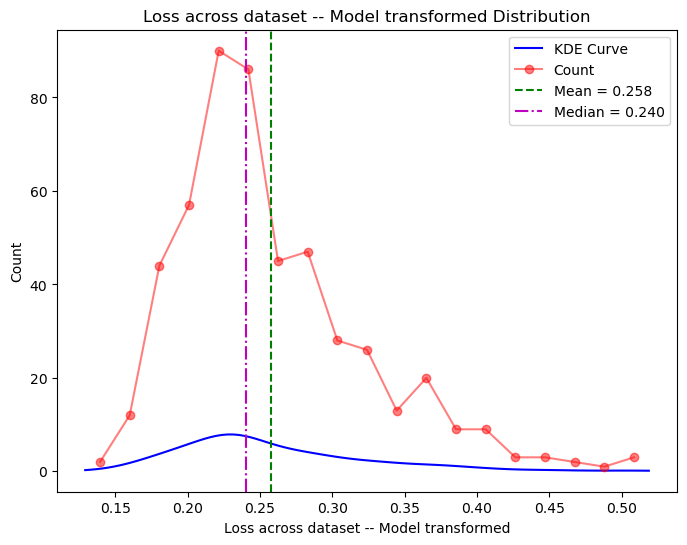

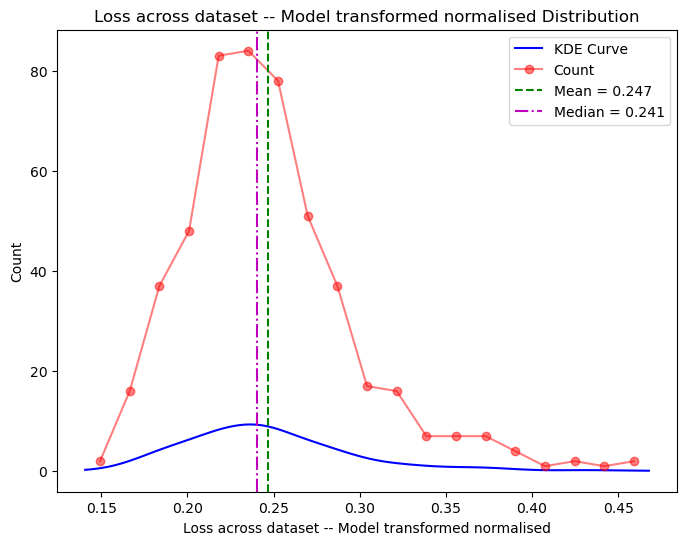

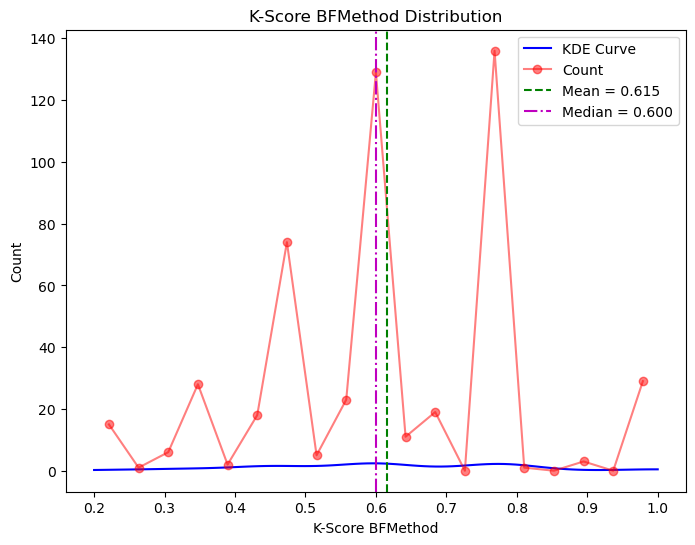

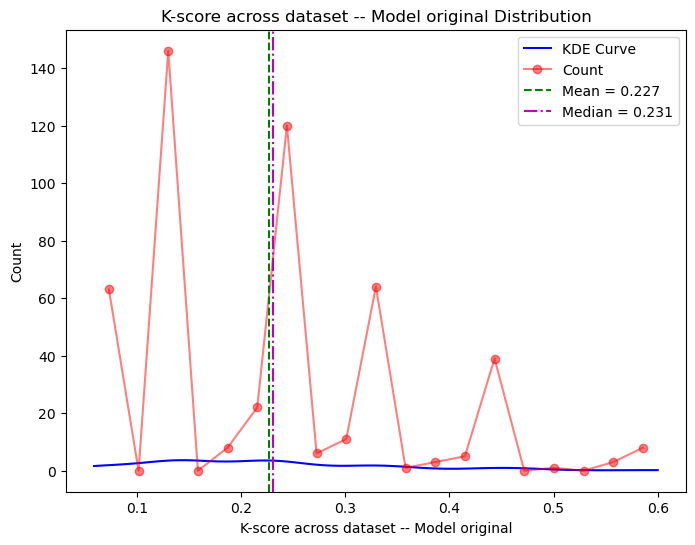

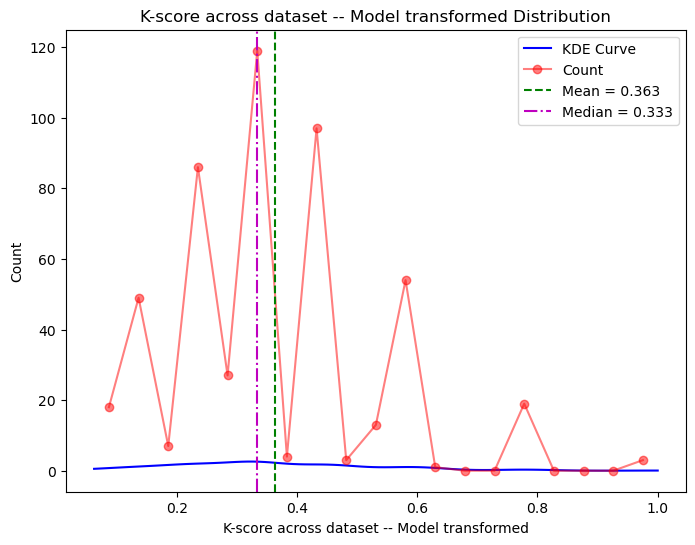

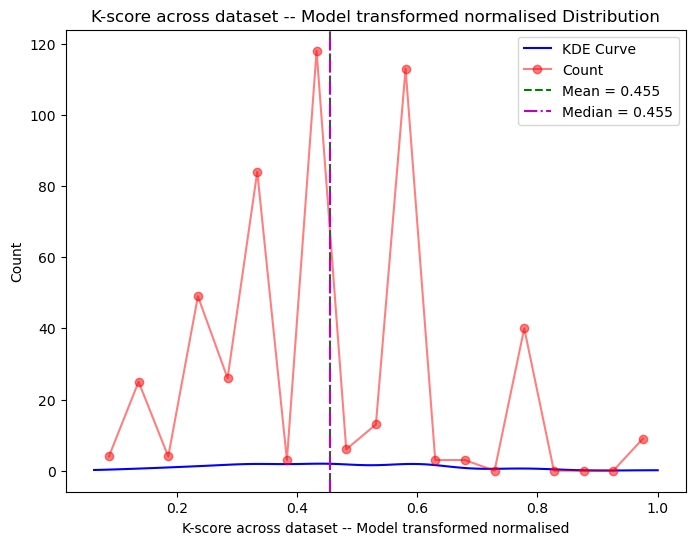

For dimension 64


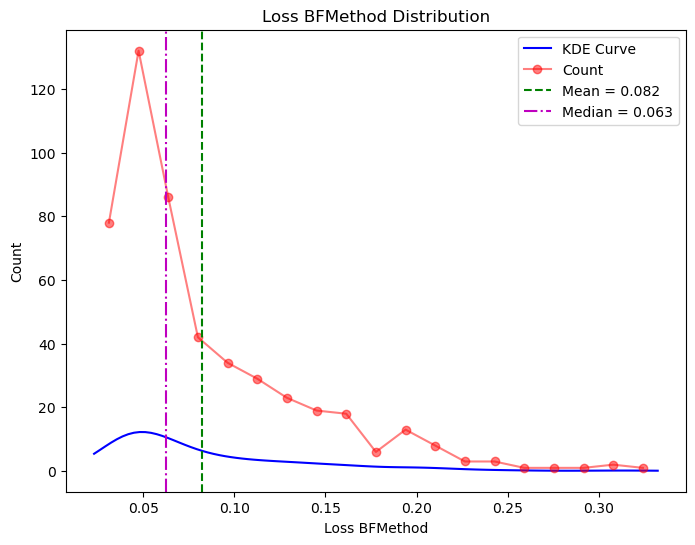

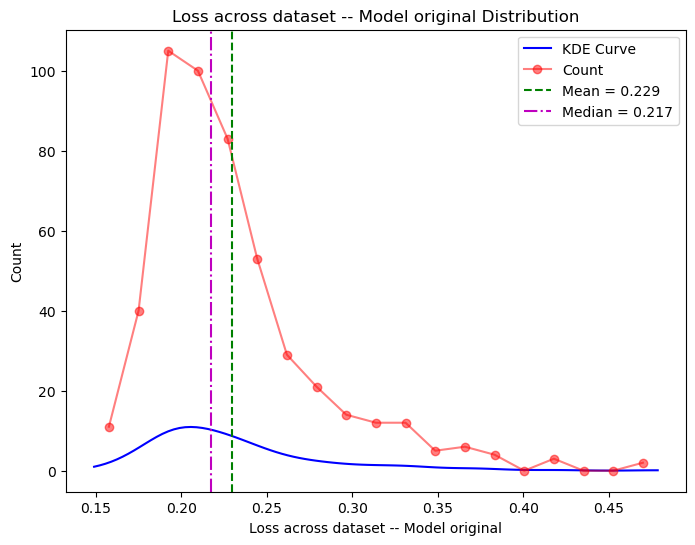

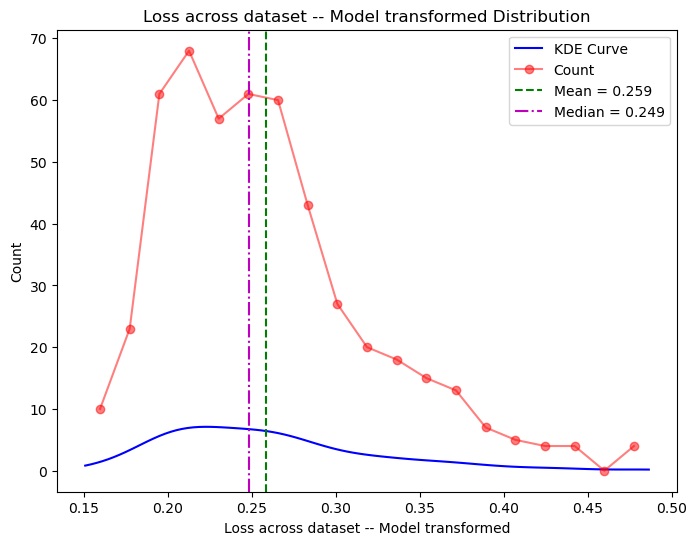

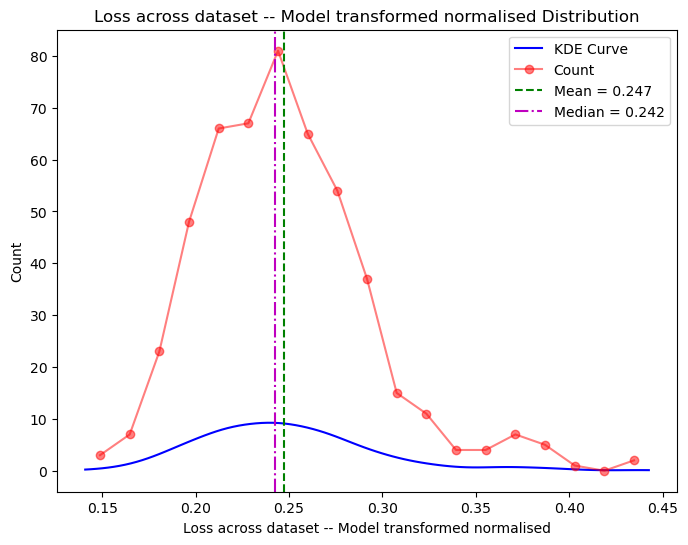

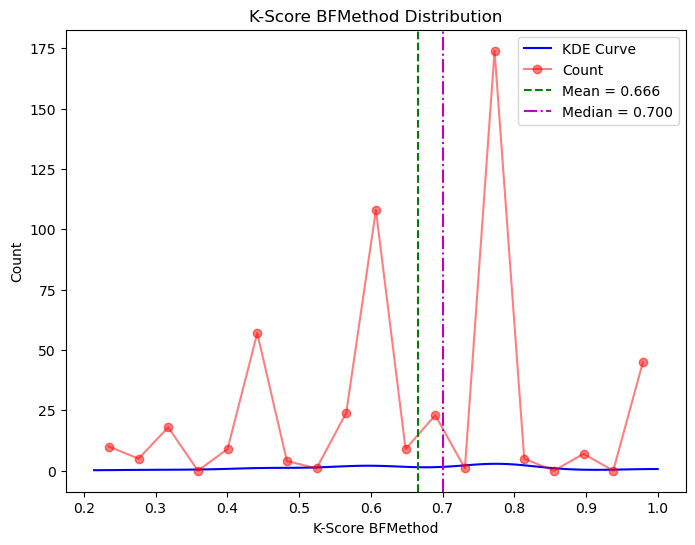

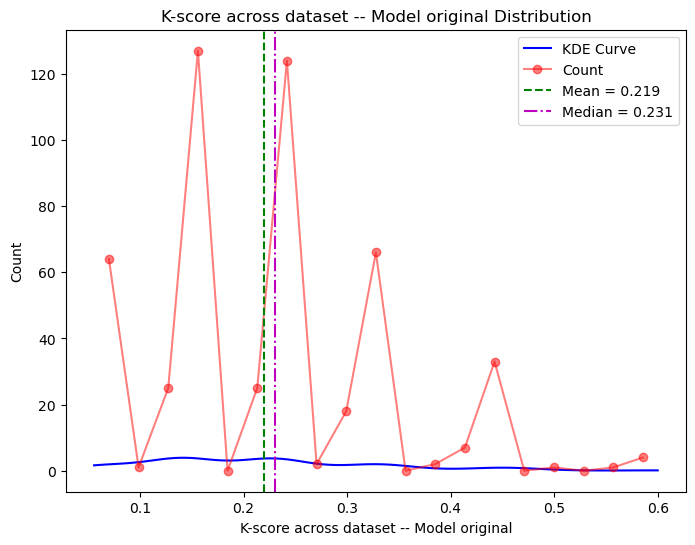

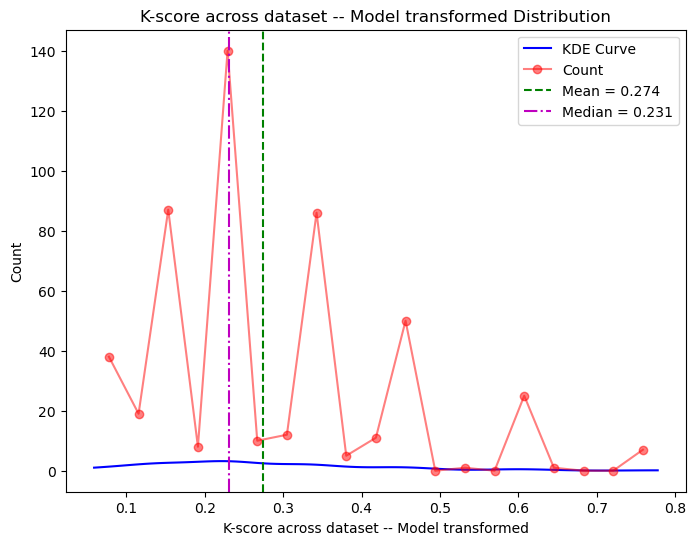

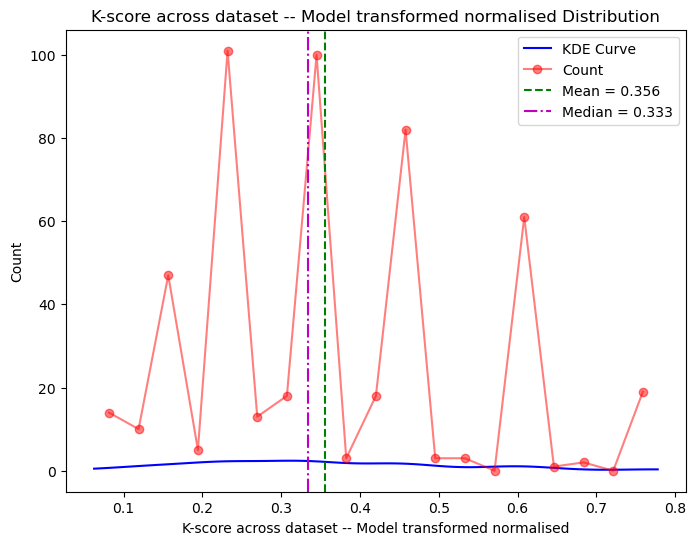

For dimension 128


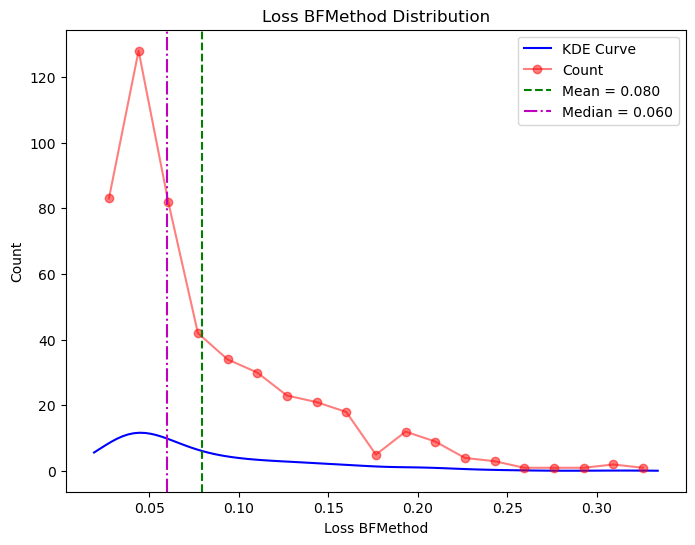

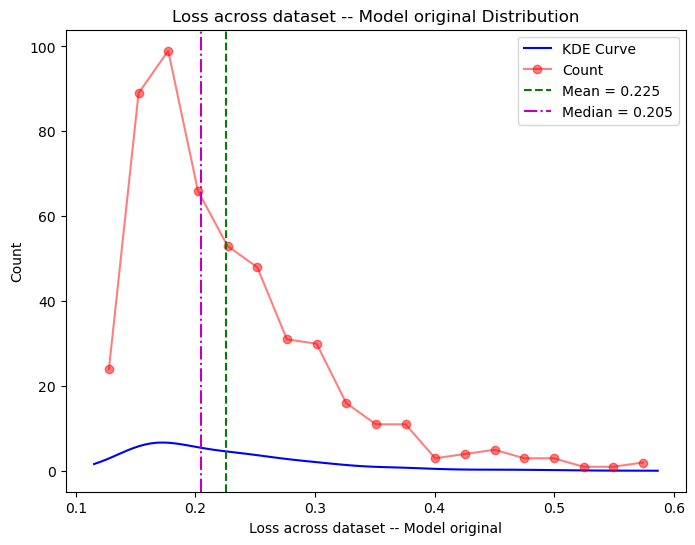

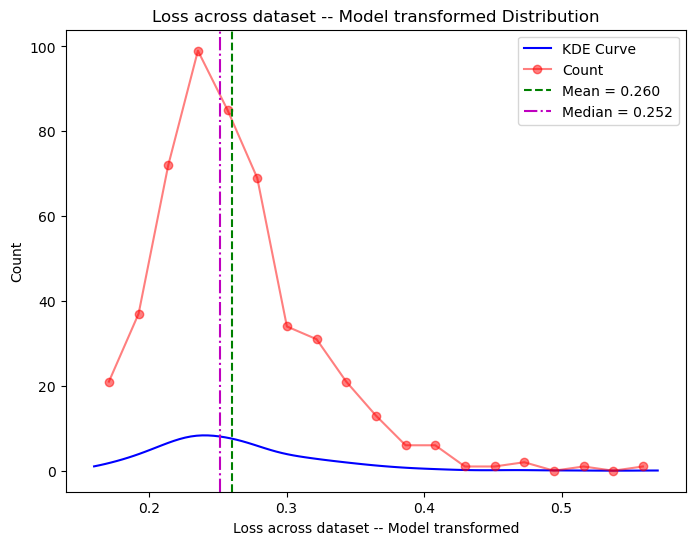

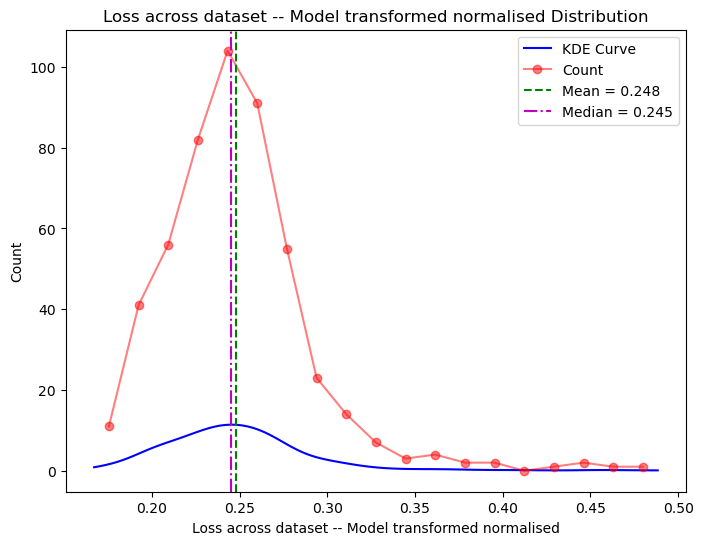

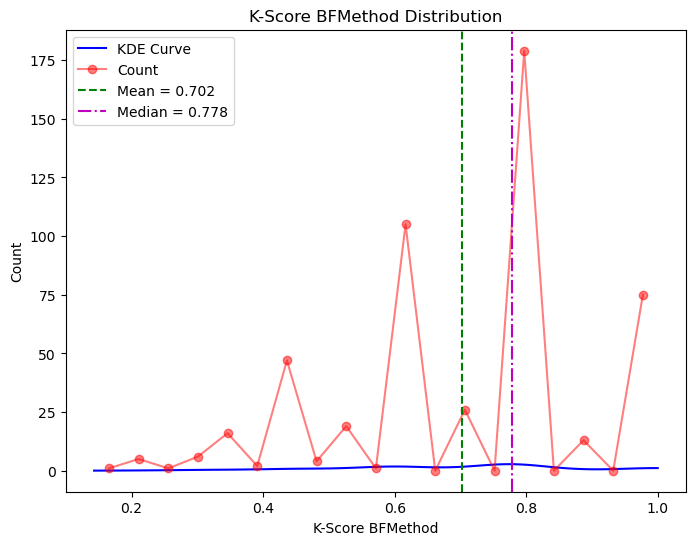

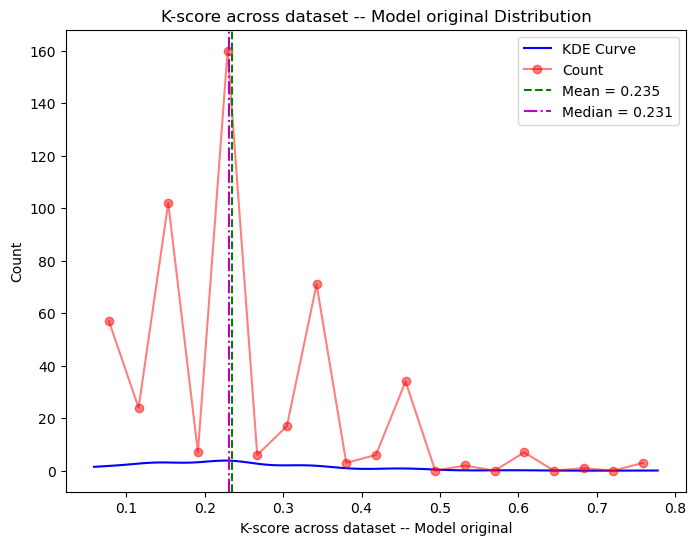

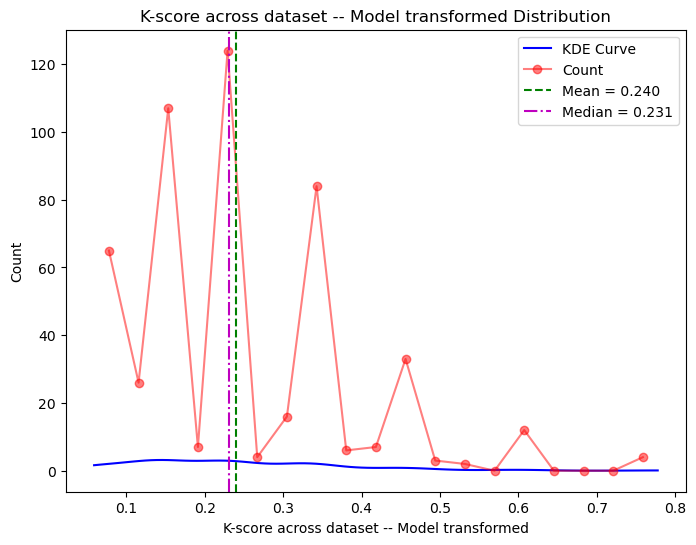

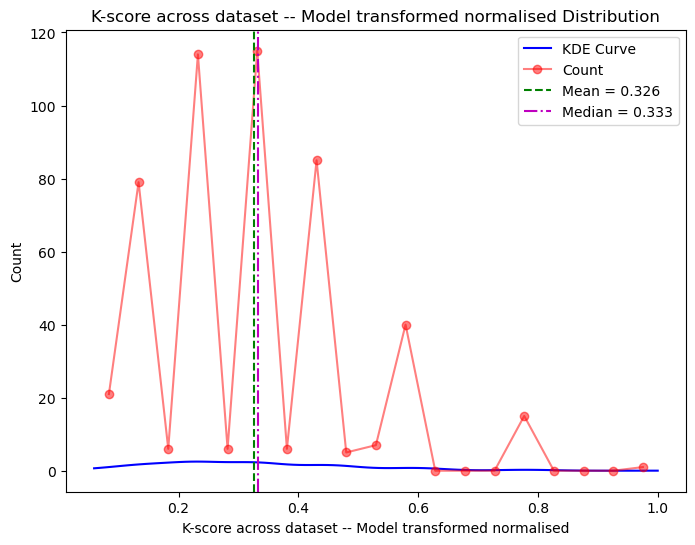

For dimension 256


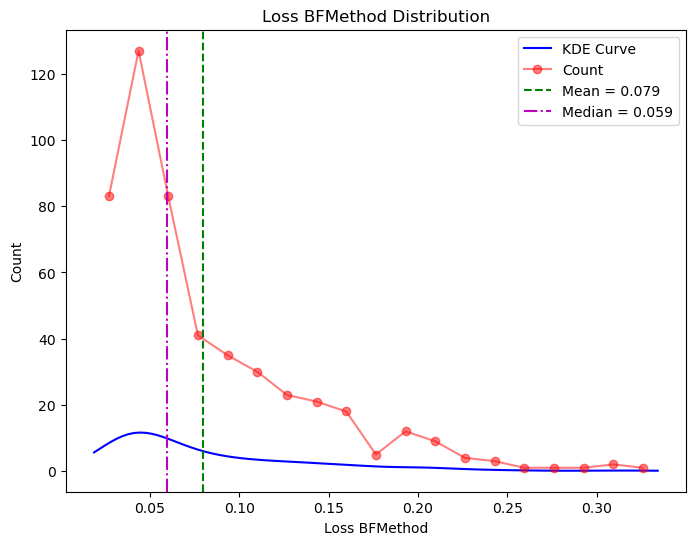

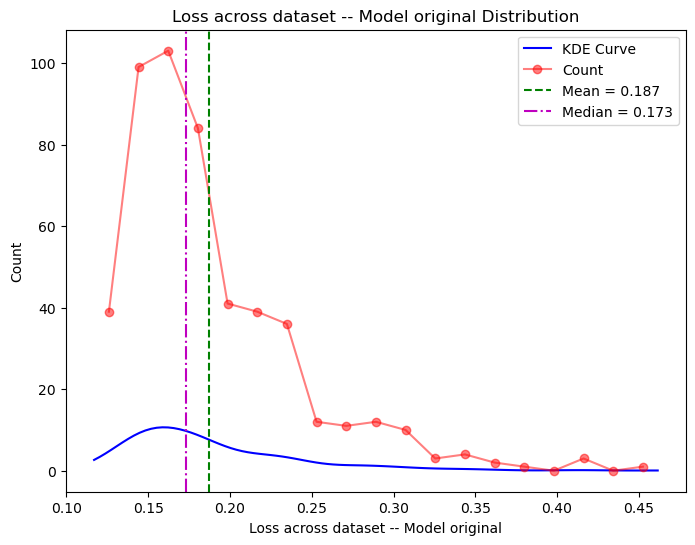

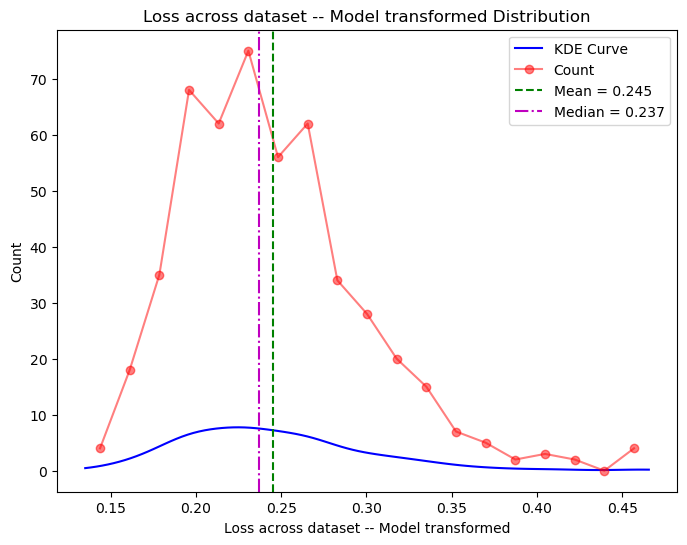

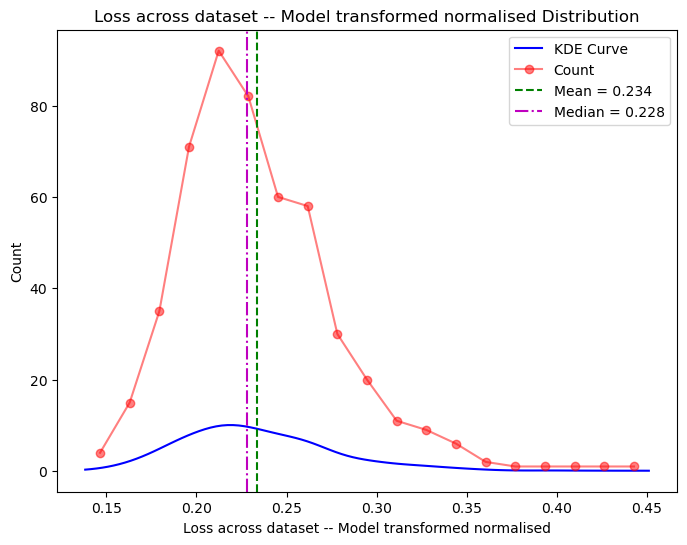

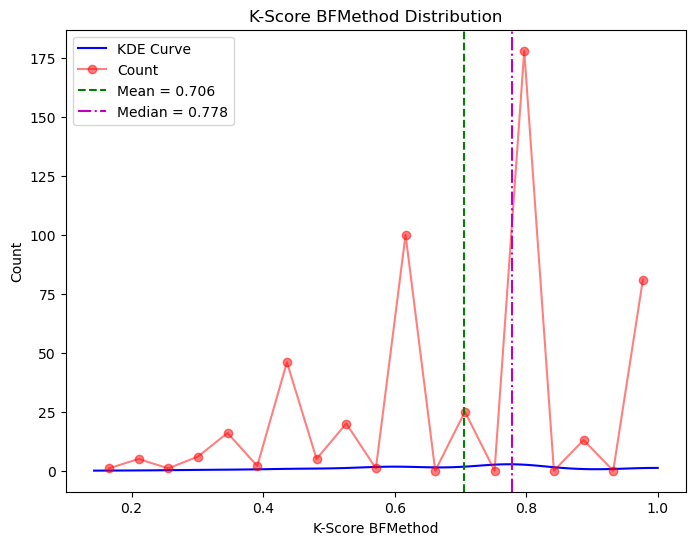

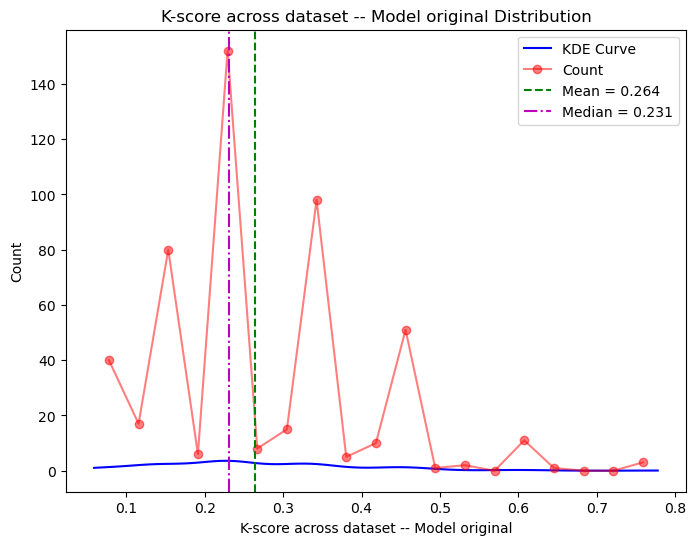

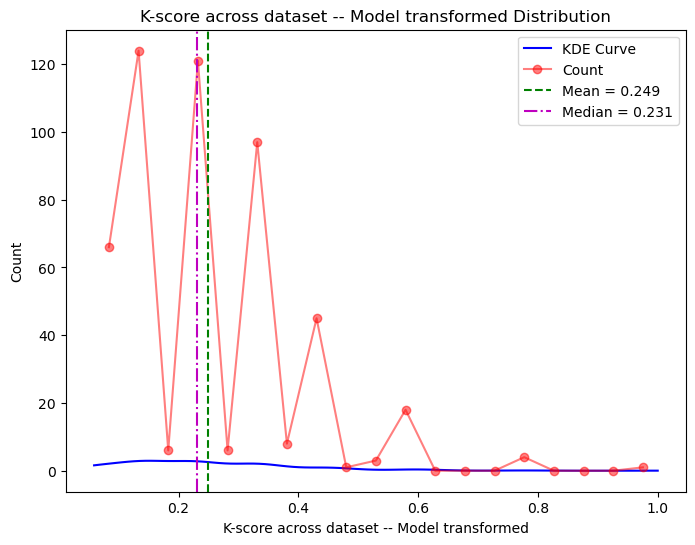

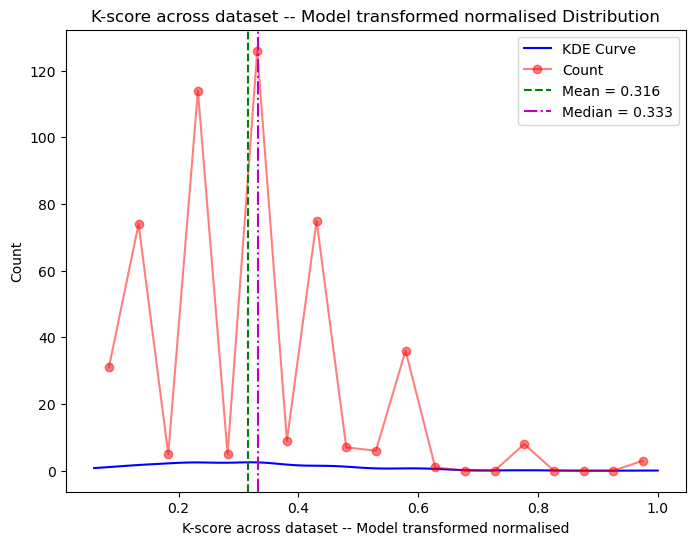

In [4]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
dimensions = [8, 16, 32, 64, 128, 256]
losses_transformed_normalised = []
losses_transformed = []
losses_original = []
kscores_transformed_normalised = []
kscores_transformed = []
kscores_original = []
losses_BFMethod = []
kscores_BFMethod = []

input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions: 
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

    kscore_transformed_normalised = []
    kscore_transformed = []
    kscore_original = []
    
    loss_original = []
    loss_transformed = []
    loss_transformed_normalised = []
    
    for i in range(num):
        vectorb = imgcalc.get_vectorb_model(i, model, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        #since after transformation, its not a unit vector
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            #since after transformation, its not a unit vector
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())

            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)

            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])

            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
            
    kscore_BFMethod, loss_BFMethod, _ = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)
    
    imgplt.plot_score_distribution(loss_BFMethod, "Loss BFMethod")
    imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
    imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
    imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
    imgplt.plot_score_distribution(kscore_BFMethod, "K-Score BFMethod")
    imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
    imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
    imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")
    
    losses_transformed_normalised.append(np.mean(loss_transformed_normalised))
    losses_transformed.append(np.mean(loss_transformed))
    losses_original.append(np.mean(loss_original))
    losses_BFMethod.append(np.mean(loss_BFMethod))
    kscores_transformed_normalised.append(np.mean(kscore_transformed_normalised))
    kscores_transformed.append(np.mean(kscore_transformed))
    kscores_original.append(np.mean(kscore_original))
    kscores_BFMethod.append(np.mean(kscore_BFMethod))
    

In [5]:
print(f"BFMethod: Loss and Kscores")
print("Kscores: ",kscores_BFMethod, np.argmax(kscores_BFMethod))
print("Losses: ",losses_BFMethod, np.argmin(losses_BFMethod))

print(f"\nOriginal Model: Loss and Kscores")
print("Kscores: ",kscores_original, np.argmax(kscores_original))
print("Losses: ",losses_original, np.argmin(losses_original))

print(f"\nTransformed Model: Loss and Kscores")
print("Kscores: ",kscores_transformed, np.argmax(kscores_transformed))
print("Losses: ",losses_transformed, np.argmin(losses_transformed))

print(f"\nTransformed Normalized Model: Loss and Kscores")
print("Kscores: ",kscores_transformed_normalised, np.argmax(kscores_transformed_normalised))
print("Losses: ",losses_transformed_normalised, np.argmin(losses_transformed_normalised))

BFMethod: Loss and Kscores
Kscores:  [0.48807012676865613, 0.5661929958929959, 0.6153775002775003, 0.665639749139749, 0.7017286269286269, 0.7058821622821623] 5
Losses:  [0.16224564440197656, 0.11285151464604015, 0.0909312541117238, 0.08234213345520815, 0.07960513896550532, 0.0794685682672371] 5

Original Model: Loss and Kscores
Kscores:  [0.19285609488550665, 0.2085311223090635, 0.22664903527844707, 0.21940024436347966, 0.23490270073064193, 0.2643298064680418] 5
Losses:  [0.3315642600218654, 0.24377203658358007, 0.23059438234543056, 0.22946513995043935, 0.22529036519055815, 0.18741778198943657] 5

Transformed Model: Loss and Kscores
Kscores:  [0.2825366654587243, 0.36081191945309593, 0.36297594399064986, 0.27385863825716766, 0.2397406614627203, 0.24916681341534283] 2
Losses:  [0.25362574184177816, 0.24706437392084302, 0.257595078628473, 0.25869873776007446, 0.26024277502378446, 0.2450033289959207] 5

Transformed Normalized Model: Loss and Kscores
Kscores:  [0.42996665850489374, 0.48453

## Metric 3: Relative Squared Difference between vector embeddings
### Visualisation of Relative Squared Difference between vector embeddings, of original and transformed model using Orthogonal Procrustes, and Pencorr embeddings across dataset across dimensions


MSE between vector embeddings of dimension 8 for Pencorr (A) and Models:


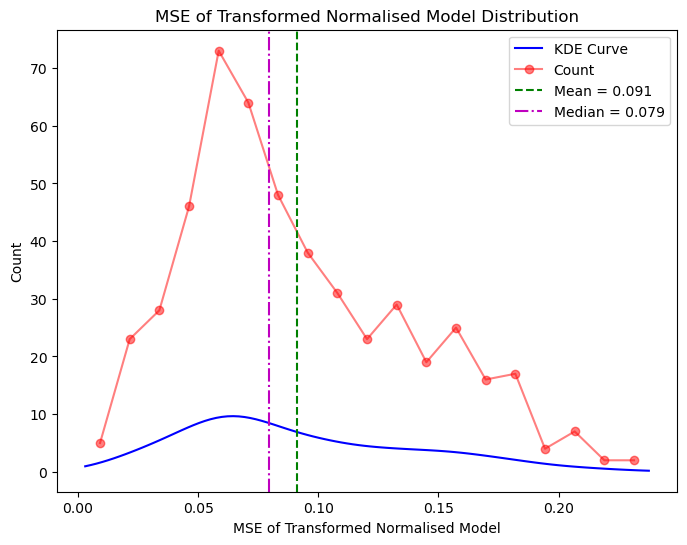

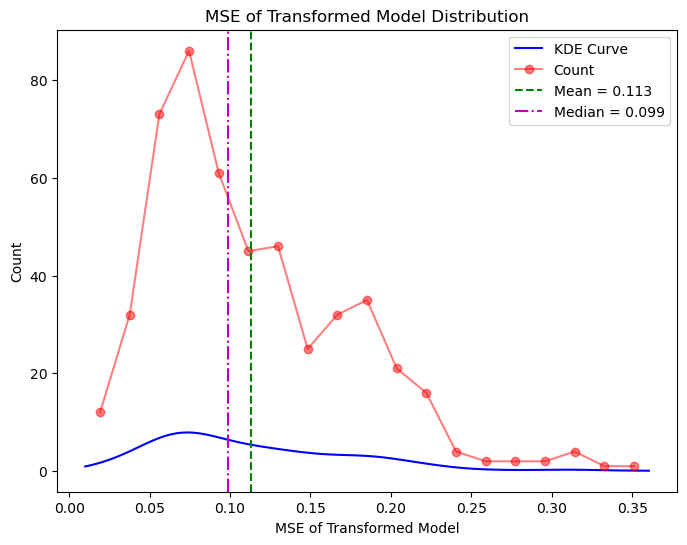

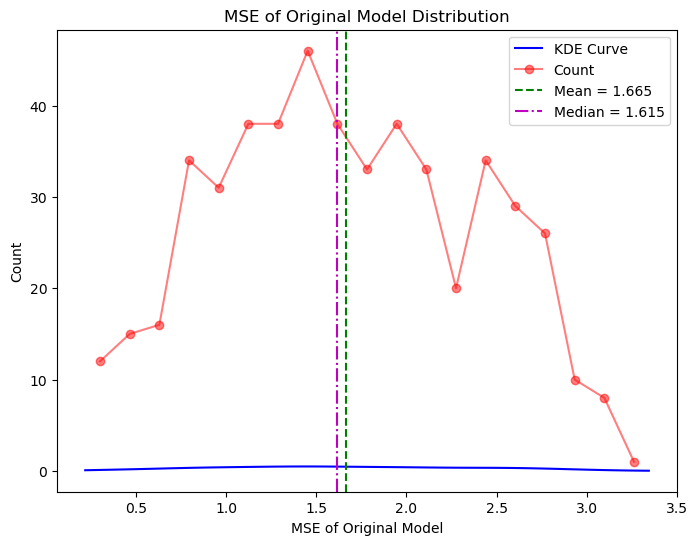


MSE between vector embeddings of dimension 16 for Pencorr (A) and Models:


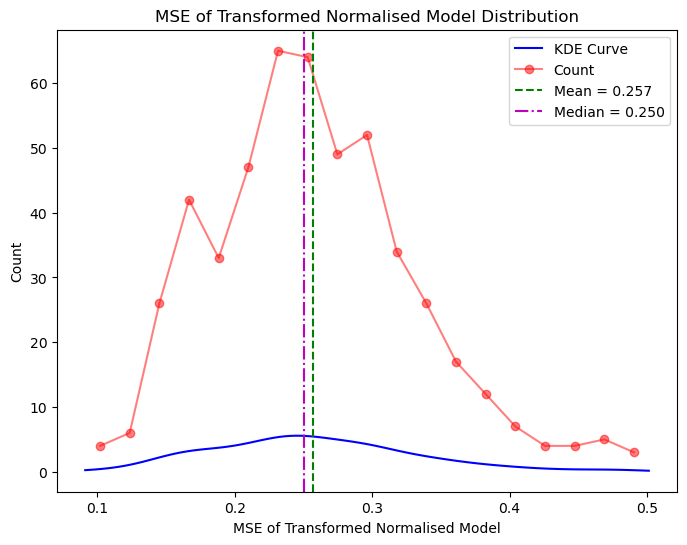

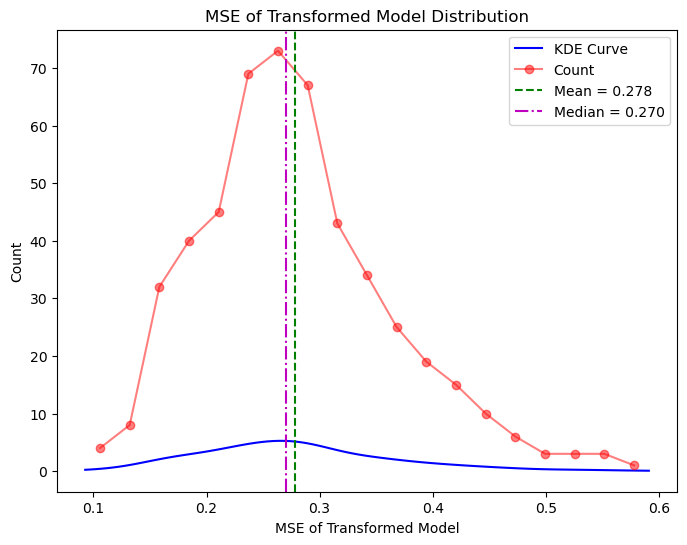

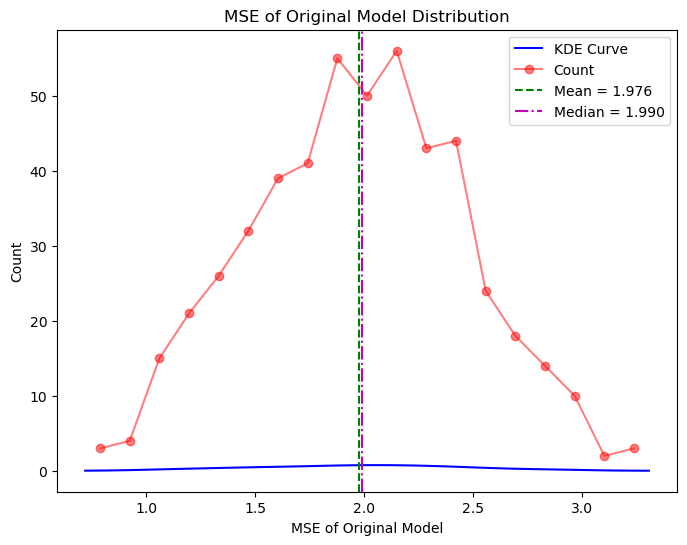


MSE between vector embeddings of dimension 32 for Pencorr (A) and Models:


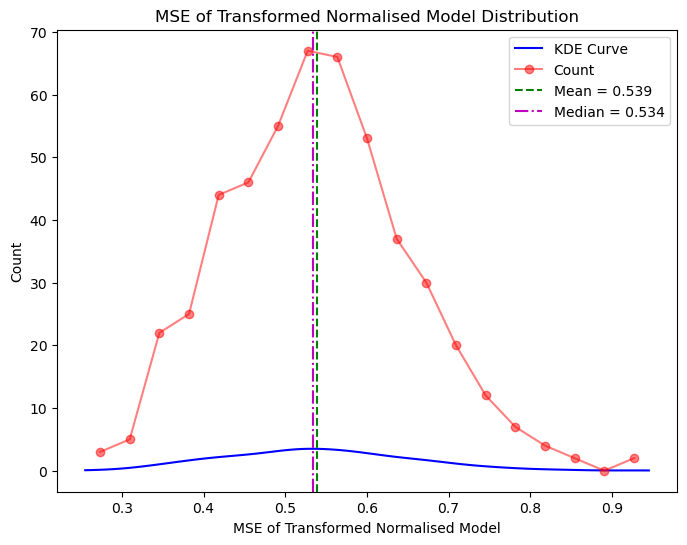

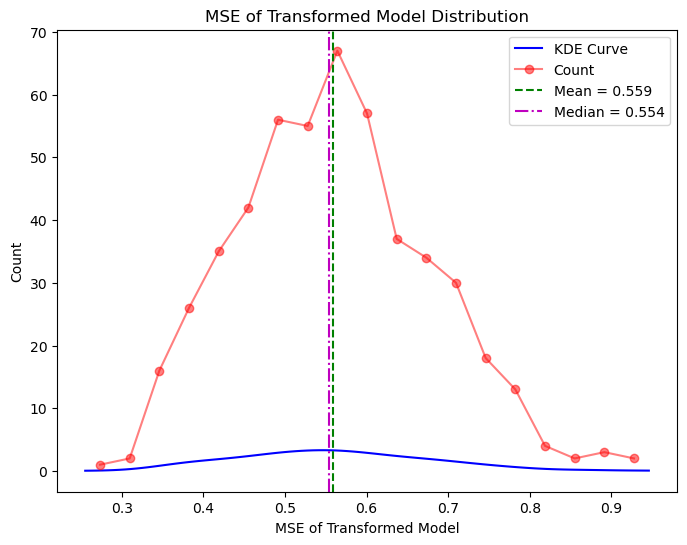

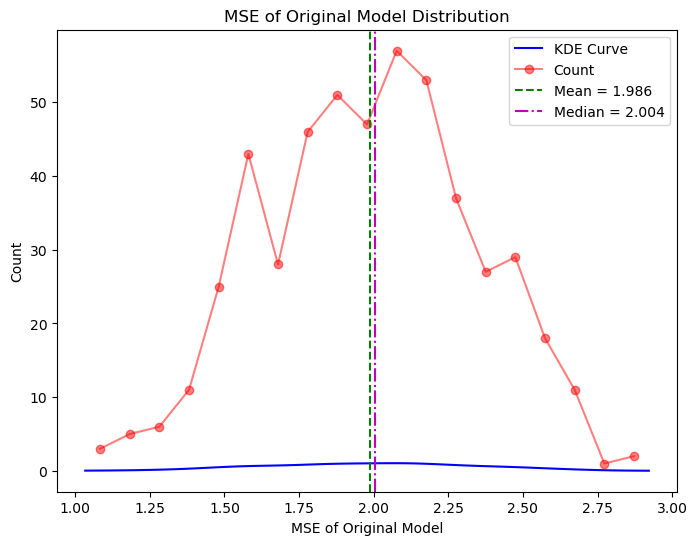


MSE between vector embeddings of dimension 64 for Pencorr (A) and Models:


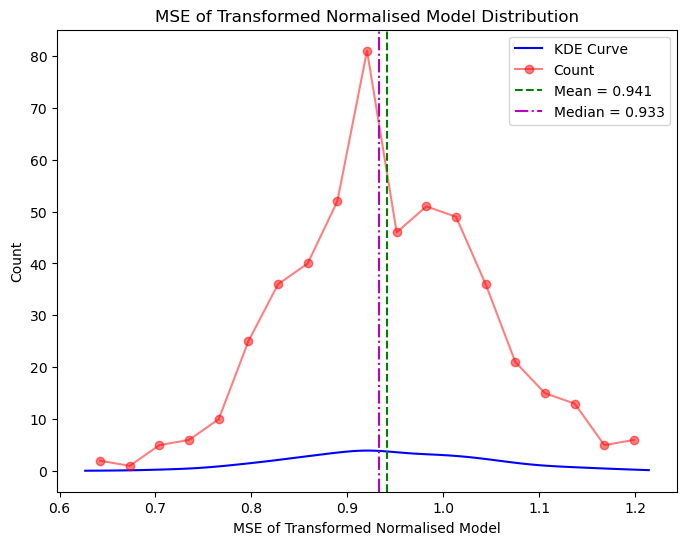

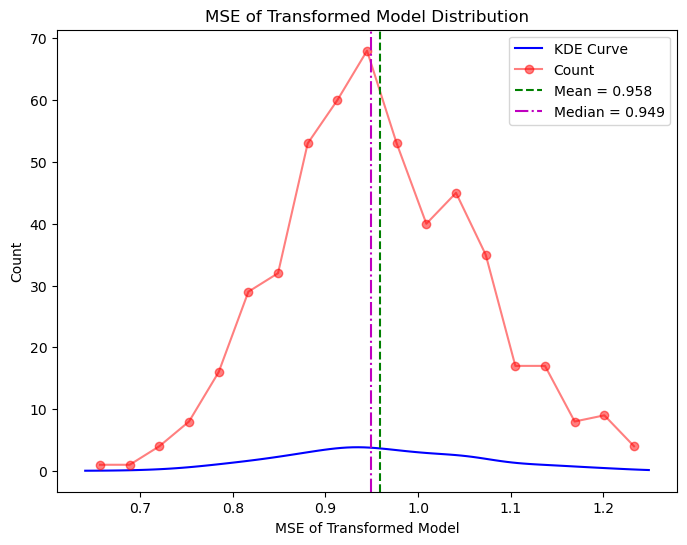

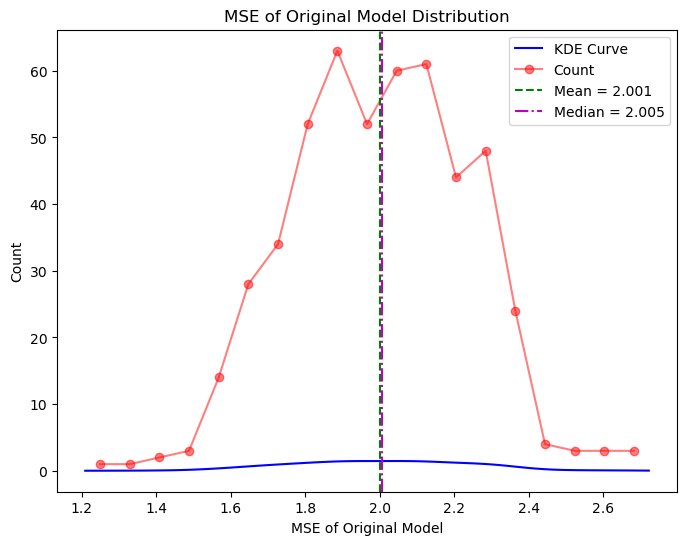


MSE between vector embeddings of dimension 128 for Pencorr (A) and Models:


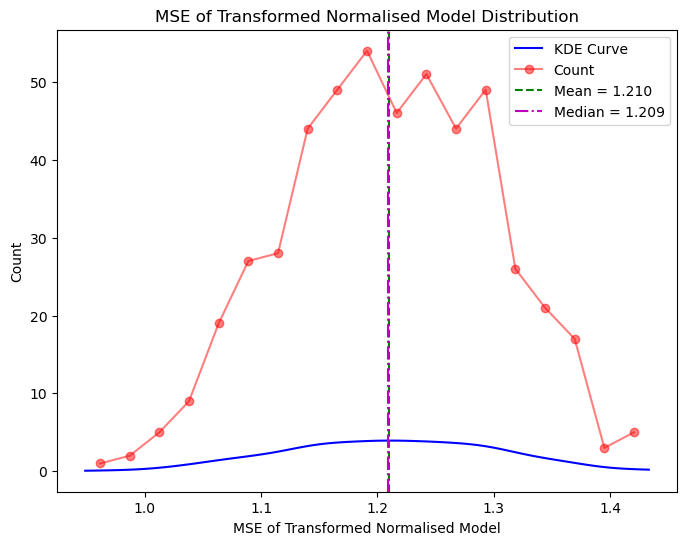

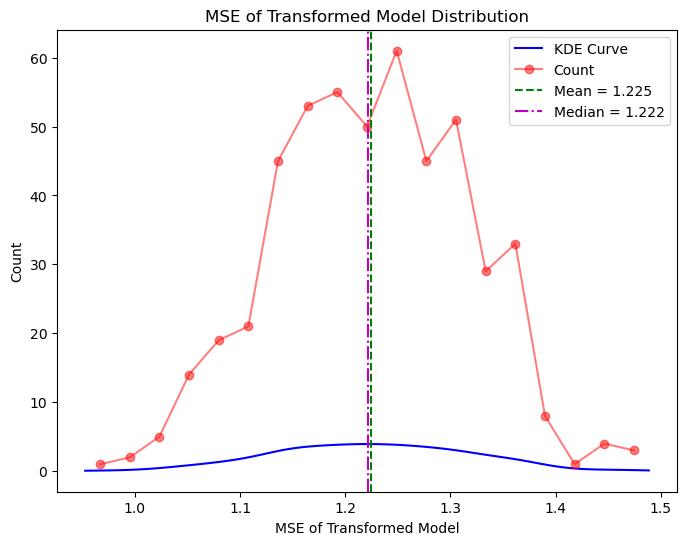

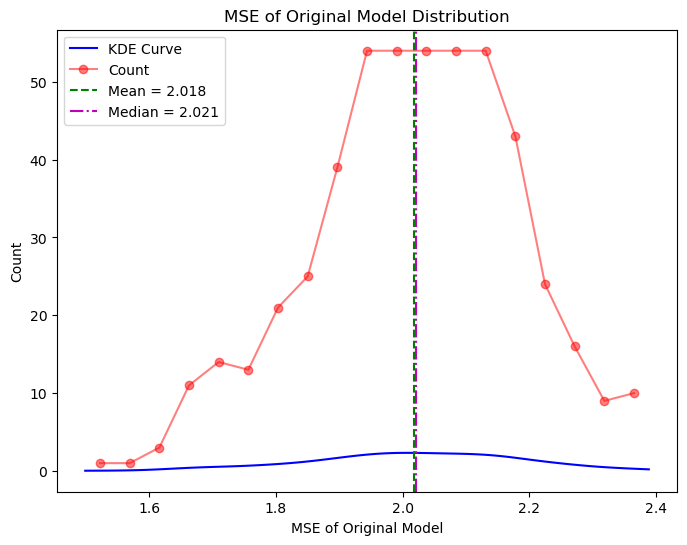


MSE between vector embeddings of dimension 256 for Pencorr (A) and Models:


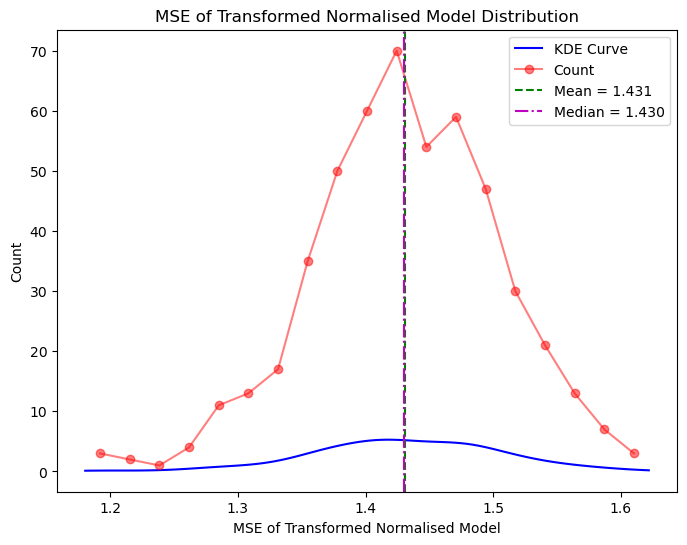

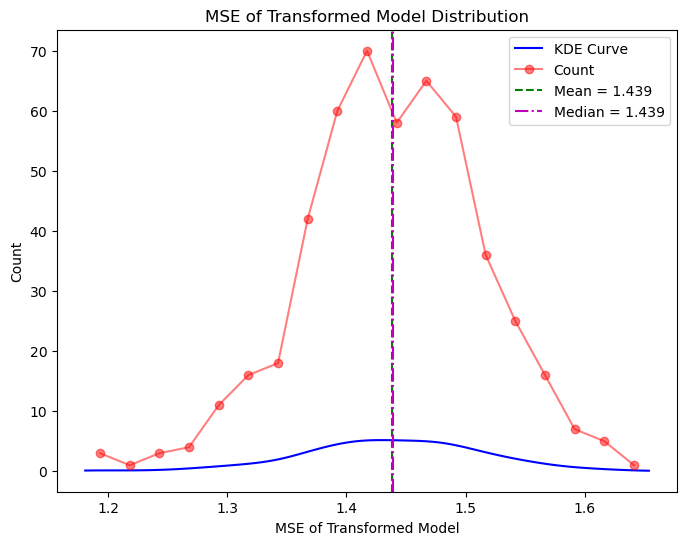

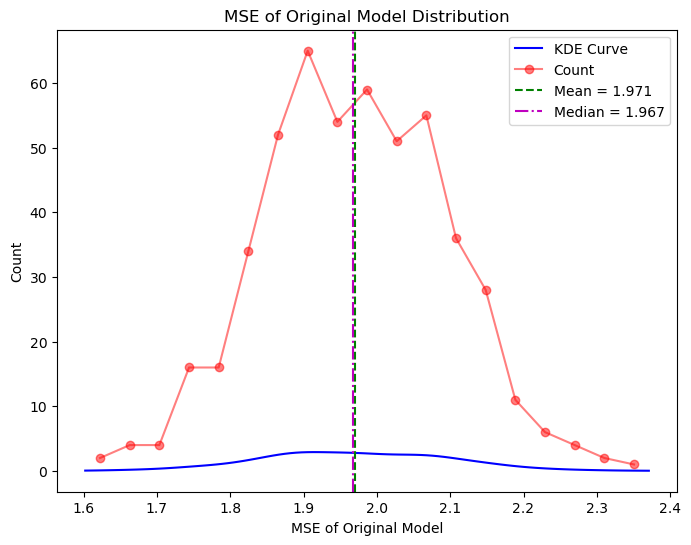

In [13]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed_normalised = []
MSD_transformed = []
MSD_original = []
dimensions = [8, 16, 32, 64, 128, 256]    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    # find a fair way to compare across the dimensions,
        # maybe can experiment with the different angles \
    MSE_transformed_normalised = []
    MSE_transformed = []
    MSE_original = []
    
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Models:")   
    for i in range(num):
        normalized_embedding = (model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())).detach().cpu().numpy()
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], normalized_embedding)
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed_normalised.append(mean_squared_difference)
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[i].detach().cpu().numpy())
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_transformed_normalised.append(np.mean(MSE_transformed_normalised))                                              
    MSD_transformed.append(np.mean(MSE_transformed))
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_transformed_normalised, f"MSE of Transformed Normalised Model")                                              
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [23]:
print("RSD Original Model: ", MSD_original, np.argmin(MSD_original))
print("RSD Transformed Model: ", MSD_transformed, np.argmin(MSD_transformed))
print("RSD Transformed Normalised Model: ", MSD_transformed_normalised, np.argmin(MSD_transformed_normalised))

RSD Original Model:  [1.6648418972950834, 1.9758035357203754, 1.9861888843901783, 2.0006841799924024, 2.018331309203943, 1.9705460720611605] 0
RSD Transformed Model:  [0.11303834240937241, 0.2784498244449845, 0.5589784446656207, 0.9584591243131244, 1.2247190200288256, 1.4385428187120581] 0
RSD Transformed Normalised Model:  [0.09093547311118738, 0.2571486421523014, 0.5389498982689043, 0.9410276709023642, 1.2103203070296882, 1.4311958856552154] 0


## Metric 4: F1 Score
### Calculation of F1 Score across dimension using original vector embeddings

In [14]:
#F1 score calculation per dimension
dimensions = [8, 16, 32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[j].detach().cpu().numpy())
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 8
F1 Score: 7.0676 for dimension 8
For dimension 16
F1 Score: 5.5312 for dimension 16
For dimension 32
F1 Score: 5.8760 for dimension 32
For dimension 64
F1 Score: 5.7021 for dimension 64
For dimension 128
F1 Score: 4.9990 for dimension 128
For dimension 256
F1 Score: 5.6635 for dimension 256


In [28]:
#F1 score calculation per dimension transformed
dimensions = [8, 16, 32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_transformed[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[j].detach().cpu().numpy())
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 8
F1 Score: 12.0827 for dimension 8
For dimension 16
F1 Score: 9.9133 for dimension 16
For dimension 32
F1 Score: 10.4140 for dimension 32
For dimension 64
F1 Score: 8.8687 for dimension 64
For dimension 128
F1 Score: 9.1213 for dimension 128
For dimension 256
F1 Score: 9.6791 for dimension 256


In [26]:
#F1 score calculation per dimension transformed normalised
dimensions = [8, 16, 32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        normalized_embedding_i = (model_transformed[top_1_index]/np.linalg.norm(model_transformed[top_1_index].detach().cpu().numpy())).detach().cpu().numpy()
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], normalized_embedding_i)
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            normalized_embedding_j = (model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())).detach().cpu().numpy()
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], normalized_embedding_j)
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 8
F1 Score: 12.0175 for dimension 8
For dimension 16
F1 Score: 9.4427 for dimension 16
For dimension 32
F1 Score: 10.3259 for dimension 32
For dimension 64
F1 Score: 8.6256 for dimension 64
For dimension 128
F1 Score: 9.2224 for dimension 128
For dimension 256
F1 Score: 9.2951 for dimension 256


# Obtaining the optimal dimension using 4 different metrics above

In [29]:
from collections import Counter
dimensions = [8, 16, 32, 64, 128, 256]


metric1 = np.argmax(kscores_original)
metric2 = np.argmin(losses_original)
metric3A = np.argmin(MSD_original)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 256


In [31]:
def find_optimal_dim(losses, eps=0.05):  
    """
    Finds the optimal dimension based on the embedding loss function.

    :param losses: Dictionary {dimension: loss value}
    :param eps: Threshold percentage (default 0.05)
    :return: The optimal dimension
    """
    L_inf = min(losses.values())

    for d in sorted(losses.keys()): 
        if L_inf == 0 or (losses[d] - L_inf) / L_inf <= eps:  
            return d  

    return max(losses.keys()) 

# Example Usage:
losses = {8: 0.17436, 16: 0.10059, 32: 0.08990, 64: 0.09155, 128: 0.09328, 256: 0.0636}
optimal_dim = find_optimal_dim(losses)
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 256


In [7]:
# -------------- for debugging -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 154
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than tolerance: 154

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.159